# Probabilistic Programming and Bayesian Methods for Hackers Chapter  5

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/TensorFlow_Probability_Case_Study_Covariance_Estimation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/TensorFlow_Probability_Case_Study_Covariance_Estimation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

Original content ([this Jupyter notebook](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC2.ipynb#Example:-Kaggle-contest-on-Observing-Dark-World)) created by Cam Davidson-Pilon ([`@Cmrn_DP`](https://twitter.com/Cmrn_DP)) and Tim Salimans ([`@TimSalimans`](https://twitter.com/TimSalimans))

Ported to Tensorflow Probability by Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)), with help from the TFP team at  Google ([`@Google`](https://twitter.com/Google)).

---
> [Dependencies & Prerequisites](https://colab.research.google.com/drive/1JZ0Zjq3kwBOrG6Av8T2yxL4oWFPMGXwy#scrollTo=3r8evK75Hyay)

> [Example: Optimizing for the Showcase on The Price is Right]()

>>> [Minimizing our losses]()

>>> [Shortcuts]()

>> [Machine Learning via Bayesian Methods]()

> [Example: Kaggle contest on Observing Dark World]()

>> [Setup]()

>>> [Defining our galaxy-plotting function]()

>> [Examining Our Data]()

>> [Priors]()

>> [Training & Tensorflow implemenation]()

>>> [Constructing a probabilistic model for the data (observed ellipcities o the galaxies) given the positions of the dark matter halos]()

>>> [Using Bayes' rule to get the posterior distribution of the halo positions, i.e. to use the data to guess wherre the dark matter halos might be]()

>> [References]()

______

## Loss Functions


### Dependencies & Prerequisites

In [0]:
!pip3 install -q tfp-nightly

In [0]:
!pip3 install -q pymc3

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import scipy.stats as stats
from IPython.core.pylabtools import figsize

import tensorflow as tf                            # importing Tensorflow
# assert tf.test.is_gpu_available()

import tensorflow_probability as tfp               # Tensorflow probability
from tensorflow_probability import edward2 as ed   # Edwardlib extension

tfd = tfp.distributions             # Basic probability distribution toolkit

dtype = np.float32    # A tool to make sure we're inputing the right data type

%matplotlib inline
plt.style.use('fivethirtyeight')        # Styling plots like FiveThirtyEight

%config InlineBackend.figure_format='retina' # improves resolution of plots

import warnings
warnings.filterwarnings('ignore')       # Some python imports raise depreciation warnings

In [0]:
def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """Convenience function to create the TF graph & session or reset them."""
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)


## Example: Optimizing for the *Showcase* on *The Price is Right*

Bless you if you are ever chosen as a contestant on the Price is Right, for here we will show you how to optimize your final price on the *Showcase*. For those who forget the rules:


1. Two contestants compete in *The Showcase*. 
2. Each contestant is shown a unique suite of prizes.
3. After the viewing, the contestants are asked to bid on the price for their unique suite of prizes.
4. If a bid price is over the actual price, the bid's owner is disqualified from winning.
5. If a bid price is under the true price by less than $250, the winner is awarded both prizes.

The difficulty in the game is balancing your uncertainty in the prices, keeping your bid low enough so as to not bid over, and trying to bid close to the price.

Suppose we have recorded the *Showcases* from previous *The Price is Right* episodes and have *prior* beliefs about what distribution the true price follows. For simplicity, suppose it follows a Normal:


$$\text{True Price} \sim \text{Normal}(\mu_p, \sigma_p )$$


In a later chapter, we will actually use *real Price is Right Showcase data* to form the historical prior, but this requires some advanced Tensorflow use so we will not use it here. For now, we will assume $\mu_p = 35 000$ and $\sigma_p = 7500$.

We need a model of how we should be playing the *Showcase*. For each prize in the prize suite, we have an idea of what it might cost, but this guess could differ significantly from the true price. (Couple this with increased pressure being onstage and you can see why some bids are so wildly off). Let's suppose your beliefs about the prices of prizes also follow Normal distributions:

$$ \text{Prize}_i \sim \text{Normal}(\mu_i, \sigma_i ),\;\; i=1,2$$

This is really why Bayesian analysis is great: we can specify what we think a fair price is through the $\mu_i$ parameter, and express uncertainty of our guess in the $\sigma_i$ parameter. 

We'll assume two prizes per suite for brevity, but this can be extended to any number. 
The true price of the prize suite is then given by $\text{Prize}_1 + \text{Prize}_2 + \epsilon$, 
where $\epsilon$ is some error term.

We are interested in the updated $\text{True Price}$ given we have observed both prizes and have belief distributions about them. We can perform this using Tensorflow Probability. 

Lets make some values concrete. Suppose there are two prizes in the observed prize suite: 

1. A trip to wonderful Toronto, Canada! 
2. A lovely new snowblower!

We have some guesses about the true prices of these objects, but we are also pretty uncertain about them. I can express this uncertainty through the parameters of the Normals:


\begin{align*}
\text{snowblower} &\sim \text{Normal}(3 000, 500 ) \\
\text{Toronto} &\sim \text{Normal}(12 000, 3000 ) \\
\end{align*}

For example, I believe that the true price of the trip to Toronto is 12 000 dollars, and that there is a 68.2% chance the price falls 1 standard deviation away from this, i.e. my confidence is that there is a 68.2% chance the trip is in [9 000, 15 000].

We can create some TensorFlow code to perform inference on the true price of the suite. 

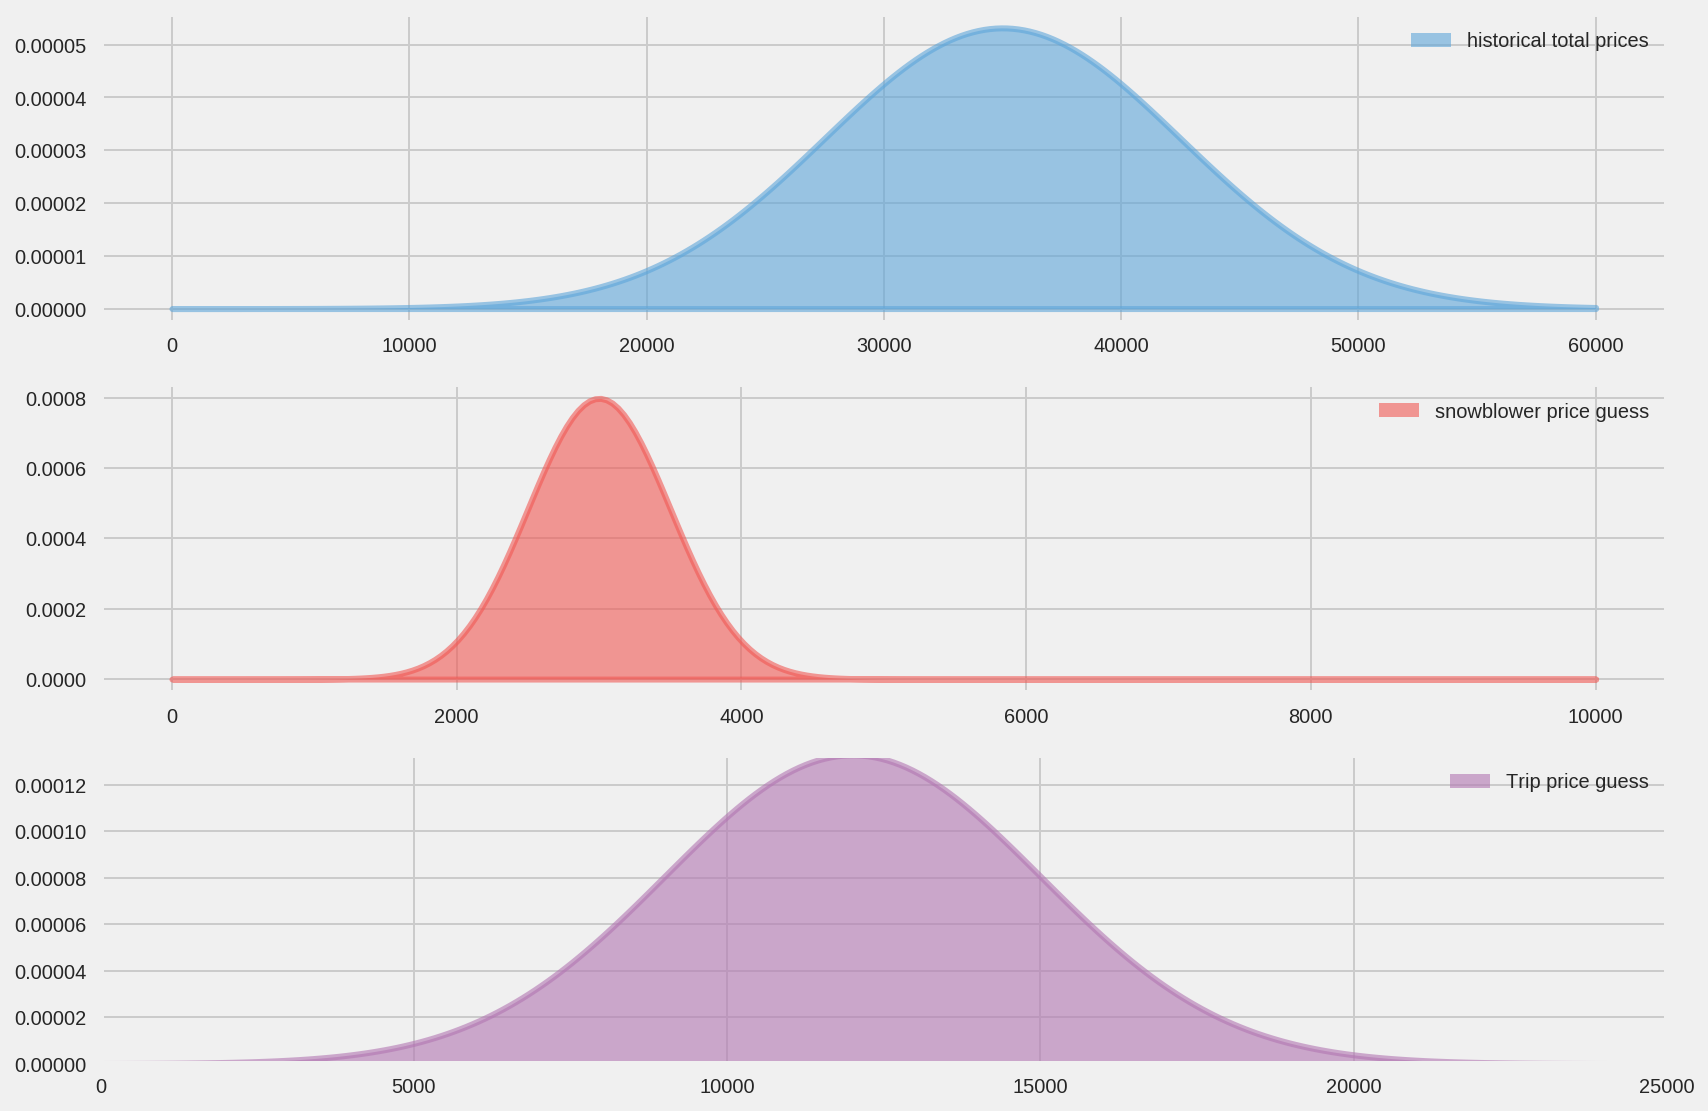

In [6]:
figsize(12.5, 9)

tf.reset_default_graph()  # Resets the default tensorflow graph we're using

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 250)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500),
                       color="#5DA5DA", lw=3, alpha=0.6,
                       label="historical total prices")
# Fun Fact: #5DA5DA is Tensorflow Blue
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 250)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500),
                       color="#F15854", lw=3, alpha=0.6,
                       label="snowblower price guess")
# Fun Fact: #F15854 is Tensorflow Red
p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 250)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
                       color="#B276B2", lw=3, alpha=0.6,
                       label="Trip price guess")
# Fun Fact: #B276B2 is Tensorflow Purple
plt.autoscale(tight=True)
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()]);

In [0]:
data_mu = [3000., 12000.]
data_std = [500., 3000.]

mu_prior = 35000.
std_prior = 7500.
    
def posterior_log_prob(true_price_, prize_1_, prize_2_):
    """
    Our posterior log probability, as a function of states
    
    Args:
      true_price_: scalar of true price estimate, taken from state
      prize_1_: scalar of prize 1 estimate, to be added to the 
      prize 1 estimate, taken from state
      prize_2_: scalar of prize 2 estimate, to be added to the 
      prize 1 estimate, taken from state
    Returns: 
      Scalar sum of log probabilities
    Closure over: data_mu, data_std, mu_prior, std_prior
    """
    rv_true_price = tfd.Normal(loc=mu_prior, scale=std_prior, name="true_price")
    rv_prize_1 = tfd.Normal(loc=data_mu[0], scale=data_std[0], name="first_prize")
    rv_prize_2 = tfd.Normal(loc=data_mu[1], scale=data_std[1], name="second_prize")
    
    price_estimate_ = prize_1_ + prize_1_
    
    error = tfd.Normal(loc=price_estimate_, scale=3000., name='error').log_prob(true_price_)
    
    return (rv_true_price.log_prob(true_price_) +
            rv_prize_1.log_prob(prize_1_) + 
            rv_prize_2.log_prob(prize_2_) + 
            error)

In [0]:
price_is_right_graph = tf.Graph()
with price_is_right_graph.as_default():
    # Operations created in this scope will be added to the graph `price_is_right_graph`

    num_results = tf.placeholder(dtype=tf.int32, name='num_results')
    num_burnin_steps = tf.placeholder(dtype=tf.int32, name='num_burnin_steps')
    
    [true_price, prize_1, prize_2], kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            tf.fill([1], 23000., name='init_true_price'),
            tf.fill([1], 3000., name='init_prize_1'),
            tf.fill([1], 12000., name='init_prize_2')
        ],
        kernel=tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=posterior_log_prob,
            seed=54),
        parallel_iterations = 1,
        name='MCMC_eval')
    
    [
        true_price_,
        prize_1_,
        prize_2_,
        is_accepted_
    ] = [
        true_price,
        prize_1,
        prize_2,
        kernel_results.is_accepted
    ]
      
    # Some of the steps of the MCMC will involve just getting close to where the right answers are
    # so we get the samples random walk, and cut off the trial (or `burn_in`) steps   
    burned_true_price_traces = tf.stack(tf.map_fn(lambda x: x[0], true_price_), axis=0)[num_burnin_steps:]
    
    # we'll take the mean and standard deviations of the samples to put
    # together the approximate posterior distribution for the true_price.
    # We'll also get 50,000 samples from the approximate posterior distribution
    posterior_price_predictive_samples = tfd.Normal(loc=tf.reduce_mean(burned_true_price_traces, axis=0), 
                                                    scale=3000., 
                                                    name='approx_posterior').sample(sample_shape=50000)
    
    # Initializing our variables in `price_is_right_graph`
    init = tf.global_variables_initializer()

In [0]:
# Checking the list of operations in our graph
with price_is_right_graph.as_default():
    [op.name for op in tf.get_default_graph().get_operations()]


Nice. Now we'll eval the result with a `tf.Session()` run and see if it matches our expectations.

In [10]:
config = tf.ConfigProto()
if tf.test.is_gpu_available() == True:
    config.gpu_options.allow_growth = True
else:
    config.gpu_options.allow_growth = False
    
with tf.Session(config=config, graph=price_is_right_graph) as sess_1:
    # This session will run operations from `price_is_right_graph`
    # `sess.graph` provides access to the graph used in a 
    # tf.Session
    writer = tf.summary.FileWriter("logs", sess_1.graph)
    
    ## If we're debugging, we can define options for the `sess.run()` call
    #
    options = tf.RunOptions()
    options.output_partition_graphs = True
    options.trace_level = tf.RunOptions.FULL_TRACE
    
    # If we're debugging, we can define a container for the returned metadata
    #
    metadata = tf.RunMetadata()
    
    # Running the Initializer on our model
    sess_1.run(init)
        
    # performing our computations
    # We use the `feed_dict` to give precise values to our MCMC parameters
    [posterior_price_predictive_sample_val] = sess_1.run(fetches=[posterior_price_predictive_samples], 
                                                feed_dict={num_results: 50000,# 50000 # 10000
                                                           num_burnin_steps: 10000}) # 10000 # 3000
                                                # options=options,
                                                # run_metadata=metadata)
    
    ### If we're debugging, we can print the subgraphs that executed on each device
    # 
    print("metadata.partition_graphs:", metadata.partition_graphs)

    ### If we're debugging, we can print the timings of each operation tht executed
    #
    print("metadata.step_stats:", metadata.step_stats)
    print("posterior_price_predictive_sample_val:", posterior_price_predictive_sample_val)
    
    # Closing the summary writer for this session
    writer.close()

metadata.partition_graphs: []
metadata.step_stats: 
posterior_price_predictive_sample_val: [20911.535 22852.656 22595.656 ... 24985.707 21389.48  22693.6  ]


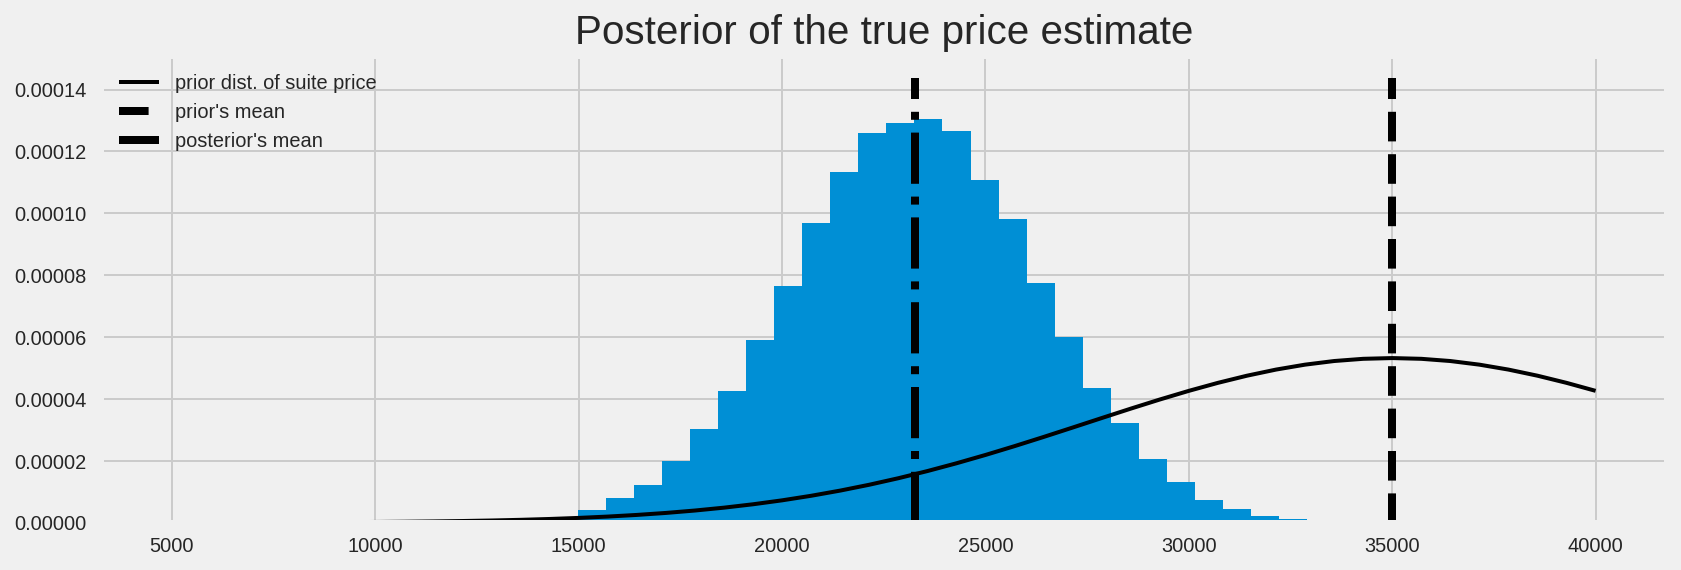

In [11]:
figsize(12.5, 4)

import scipy.stats as stats

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c="k", lw=2,
         label="prior dist. of suite price")

_hist = plt.hist(posterior_price_predictive_sample_val, bins=35, normed=True, histtype="stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1 * np.max(_hist[0]), label="prior's mean",
           linestyles="--")
plt.vlines(posterior_price_predictive_sample_val.mean(), 0, 1.1 * np.max(_hist[0]),
           label="posterior's mean", linestyles="-.")
plt.legend(loc="upper left");

Notice that because of our two observed prizes and subsequent guesses (including uncertainty about those guesses), we shifted our mean price estimate down about $15 000 dollars from the previous mean price.

A frequentist, seeing the two prizes and having the same beliefs about their prices, would bid $\mu_1 + \mu_2 = 35000$, regardless of any uncertainty. Meanwhile, the *naive Bayesian* would simply pick the mean of the posterior distribution. But we have more information about our eventual outcomes; we should incorporate this into our bid. We will use the loss function above to find the *best* bid (*best* according to our loss).

What might a contestant's loss function look like? I would think it would look something like:

    def showcase_loss(guess, true_price, risk=80000):
        if true_price < guess:
            return risk
        elif abs(true_price - guess) <= 250:
            return -2*np.abs(true_price)
        else:
            return np.abs(true_price - guess - 250)

where `risk` is a parameter that defines of how bad it is if your guess is over the true price. A lower `risk` means that you are more comfortable with the idea of going over. If we do bid under and the difference is less than $250, we receive both prizes (modeled here as receiving twice the original prize). Otherwise, when we bid under the `true_price` we want to be as close as possible, hence the `else` loss is a increasing function of the distance between the guess and true price.

For every possible bid, we calculate the *expected loss* associated with that bid. We vary the `risk` parameter to see how it affects our loss:

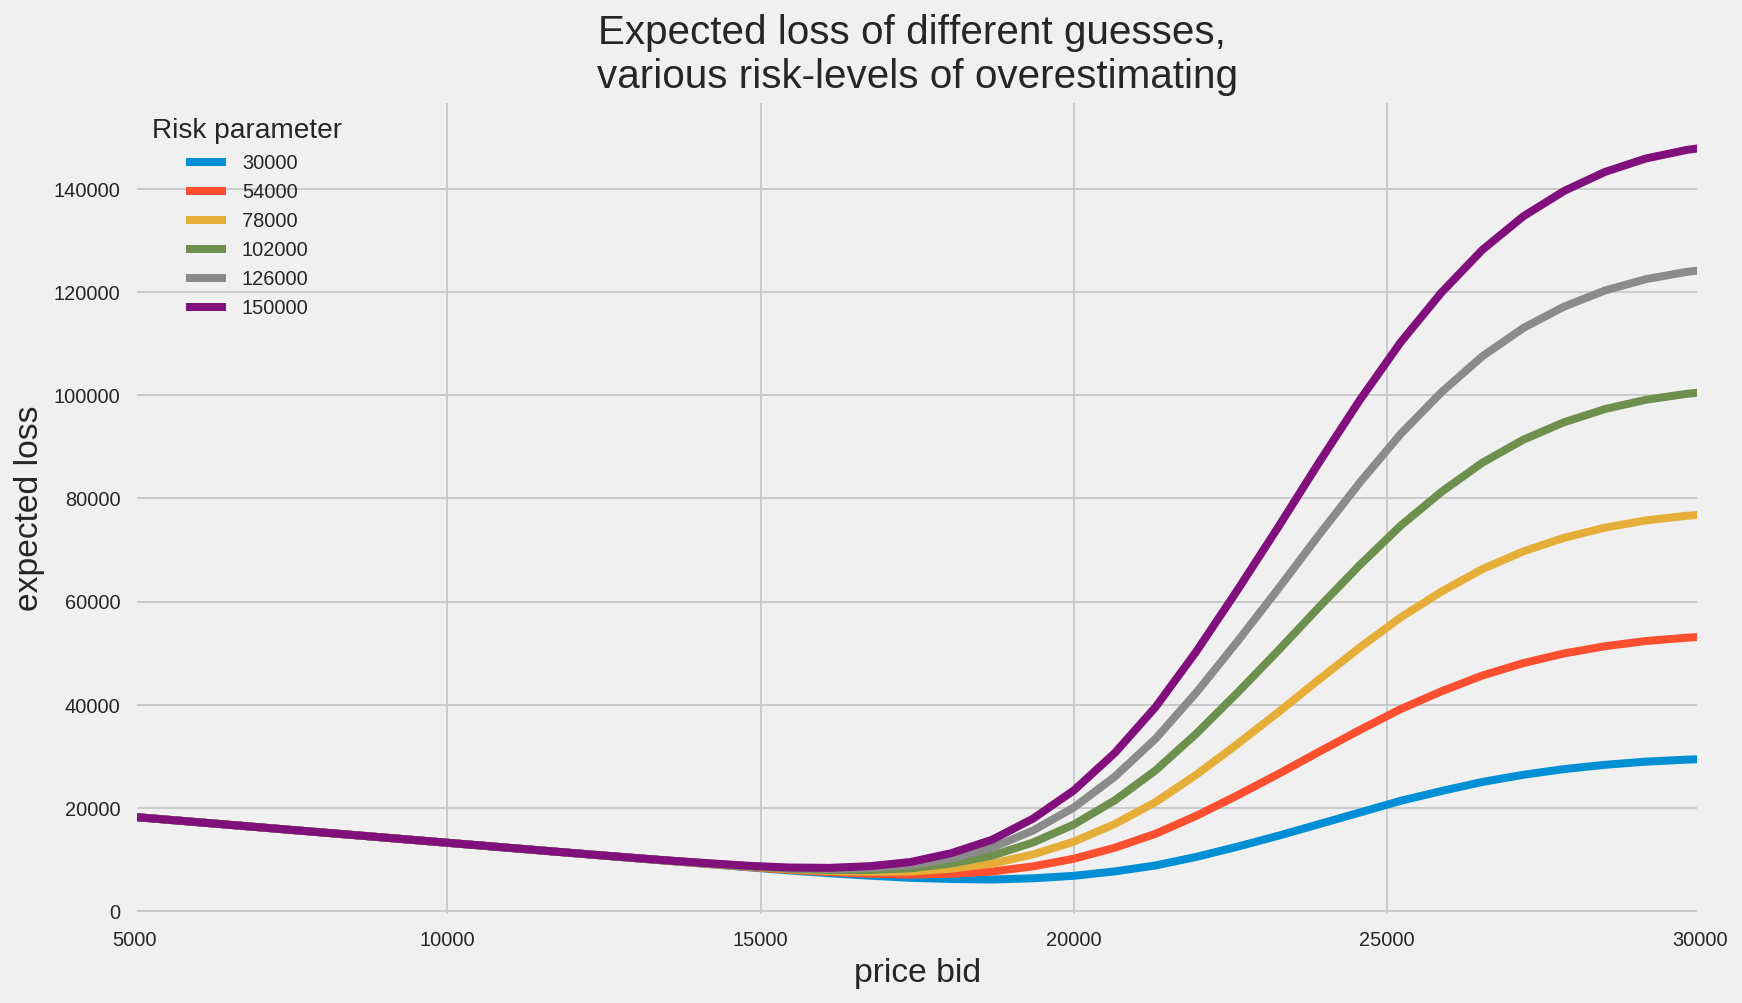

In [12]:
figsize(12.5, 7)

def showdown_loss(guess, true_price, risk=80000):
    """
    numpy friendly showdown_loss
    """
    loss = np.zeros_like(true_price)
    ix = true_price < guess
    loss[~ix] = np.abs(guess - true_price[~ix])
    close_mask = [abs(true_price - guess) <= 250]
    loss[close_mask] = -2 * true_price[close_mask]
    loss[ix] = risk
    return loss


guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, posterior_price_predictive_sample_val, risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label="%d" % _p)

plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000);


### Minimizing our losses

It would be wise to choose the estimate that minimizes our expected loss. This corresponds to the minimum point on each of the curves above. More formally, we would like to minimize our expected loss by finding the solution to

$$ \text{arg} \min_{\hat{\theta}} \;\;E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right] $$

The minimum of the expected loss is called the *Bayes action*. We can solve for the Bayes action using Scipy's optimization routines. The function in `fmin` in `scipy.optimize` module uses an intelligent search to find a minimum (not necessarily a *global* minimum) of any uni- or multivariate function. For most purposes, `fmin` will provide you with a good answer. 

We'll compute the minimum loss for the *Showcase* example above:

minimum at risk 30000: 18750.23
minimum at risk 54000: 17415.47
minimum at risk 78000: 16923.49
minimum at risk 102000: 16495.74
minimum at risk 126000: 16086.48
minimum at risk 150000: 15775.24


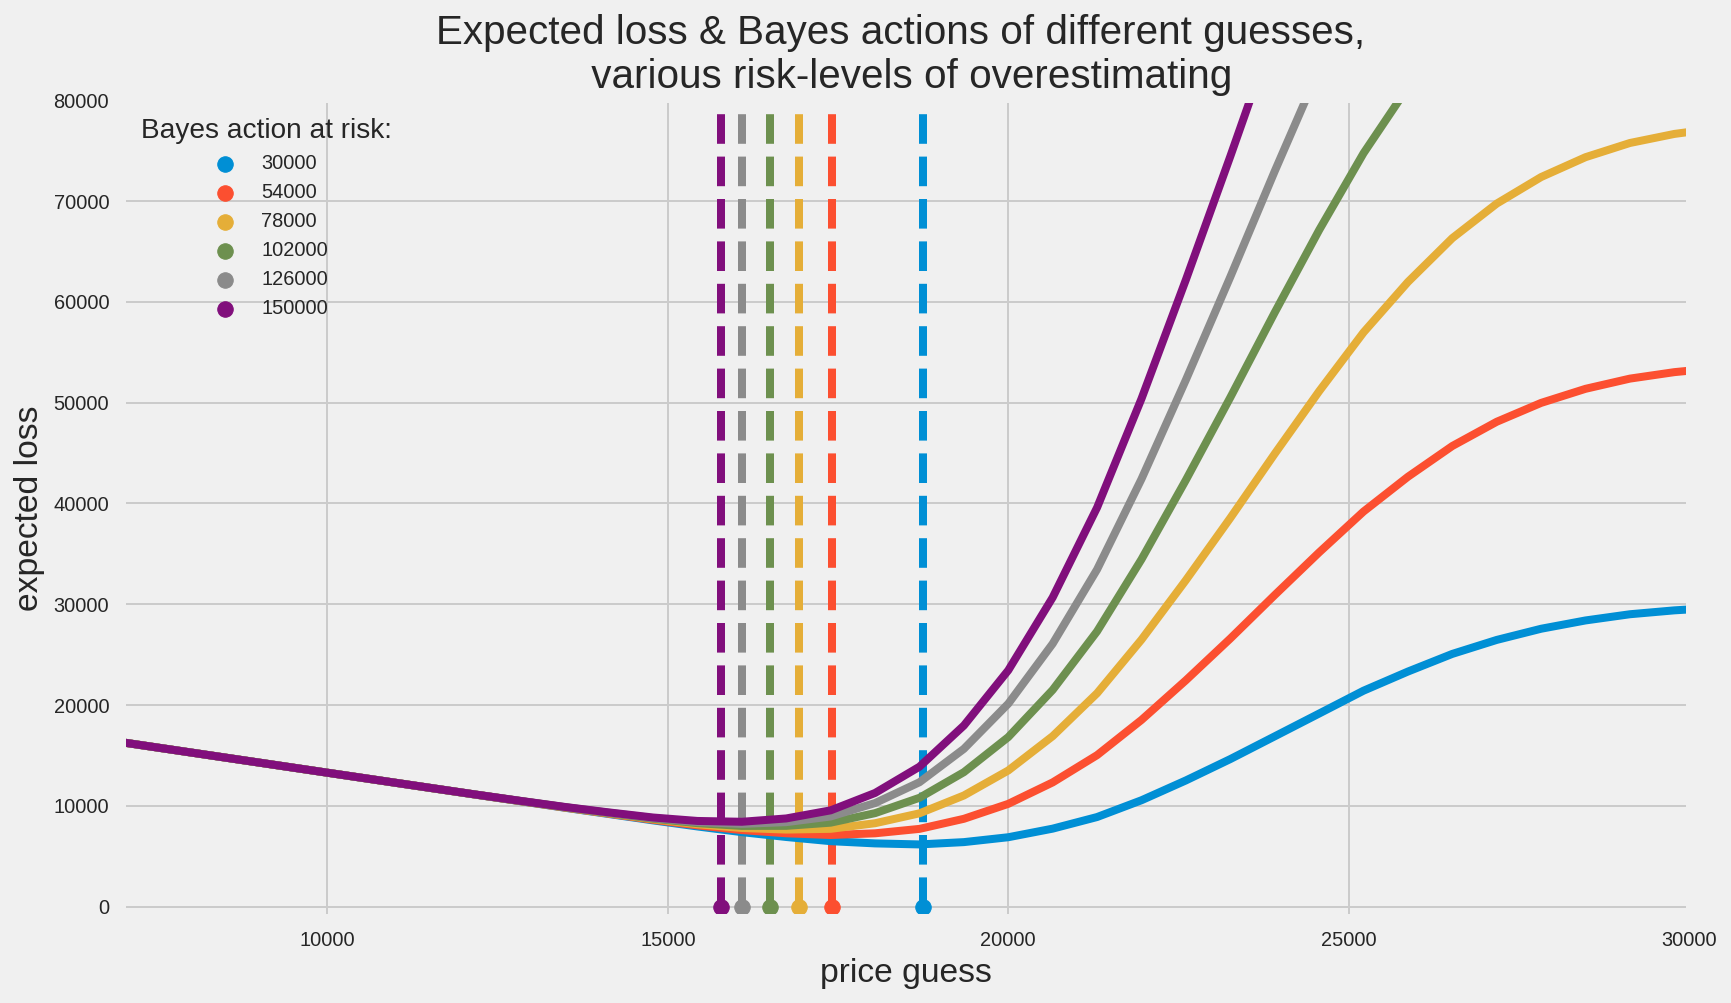

In [13]:
import scipy.optimize as sop

ax = plt.subplot(111)


for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,),disp = False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results , color = _color['color'])
    plt.scatter(_min_results, 0, s = 60, \
                color= _color['color'], label = "%d"%_p)
    plt.vlines(_min_results, 0, 120000, color = _color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))

plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints=1, title="Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);


As intuition suggests, as we decrease the risk threshold (care about overbidding less), we increase our bid, willing to edge closer to the true price. It is interesting how far away our optimized loss is from the posterior mean, which was about 20 000. 

Suffice to say, in higher dimensions being able to eyeball the minimum expected loss is impossible. Hence why we require use of Scipy's `fmin` function.


### Shortcuts

For some loss functions, the Bayes action is known in closed form. We list some of them below:

-  If using the mean-squared loss, the Bayes action is the mean of the posterior distribution, i.e. the value 
$$ E_{\theta}\left[ \theta \right] $$

>  minimizes $E_{\theta}\left[ \; (\theta - \hat{\theta})^2 \; \right]$. Computationally this requires us to calculate the average of the posterior samples [See chapter 4 on The Law of Large Numbers]

-  Whereas the *median* of the posterior distribution minimizes the expected absolute-loss. The sample median of the posterior samples is an appropriate and very accurate approximation to the true median.

-  In fact, it is possible to show that the MAP estimate is the solution to using a loss function that shrinks to the zero-one loss.


Maybe it is clear now why the first-introduced loss functions are used most often in the mathematics of Bayesian inference: no complicated optimizations are necessary. Luckily, we have machines to do the complications for us. 

## Machine Learning via Bayesian Methods

Whereas frequentist methods strive to achieve the best precision about all possible parameters, machine learning cares to achieve the best *prediction* among all possible parameters. Of course, one way to achieve accurate predictions is to aim for accurate predictions, but often your prediction measure and what frequentist methods are optimizing for are very different. 

For example, least-squares linear regression is the most simple active machine learning algorithm. I say active as it engages in some learning, whereas predicting the sample mean is technically *simpler*, but is learning very little if anything. The loss that determines the coefficients of the regressors is a squared-error loss. On the other hand, if your prediction loss function (or score function, which is the negative loss) is not a squared-error, like AUC, ROC, precision, etc., your least-squares line will not be optimal for the prediction loss function. This can lead to prediction results that are suboptimal. 

Finding Bayes actions is equivalent to finding parameters that optimize *not parameter accuracy* but an arbitrary performance measure, however we wish to define performance (loss functions, AUC, ROC, precision/recall etc.).

The next two examples demonstrate these ideas. The first example is a linear model where we can choose to predict using the least-squares loss or a novel, outcome-sensitive loss. 

The second example is adapted from a Kaggle data science project. The loss function associated with our predictions is incredibly complicated. 

# Example: Financial prediction


Suppose the future return of a stock price is very small, say 0.01 (or 1%). We have a model that predicts the stock's future price, and our profit and loss is directly tied to us acting on the prediction.  How should we measure the loss associated with the model's predictions, and subsequent future predictions? A squared-error loss is agnostic to the signage and would penalize a prediction of -0.01 equally as bad a prediction of 0.03:

$$ (0.01 - (-0.01))^2 = (0.01 - 0.03)^2 = 0.004$$

If you had made a bet based on your model's prediction, you would have earned money with a prediction of 0.03, and lost money with a prediction of -0.01, yet our loss did not capture this. We need a better loss that takes into account the *sign* of the prediction and true value. We design a new loss that is better for financial applications below:

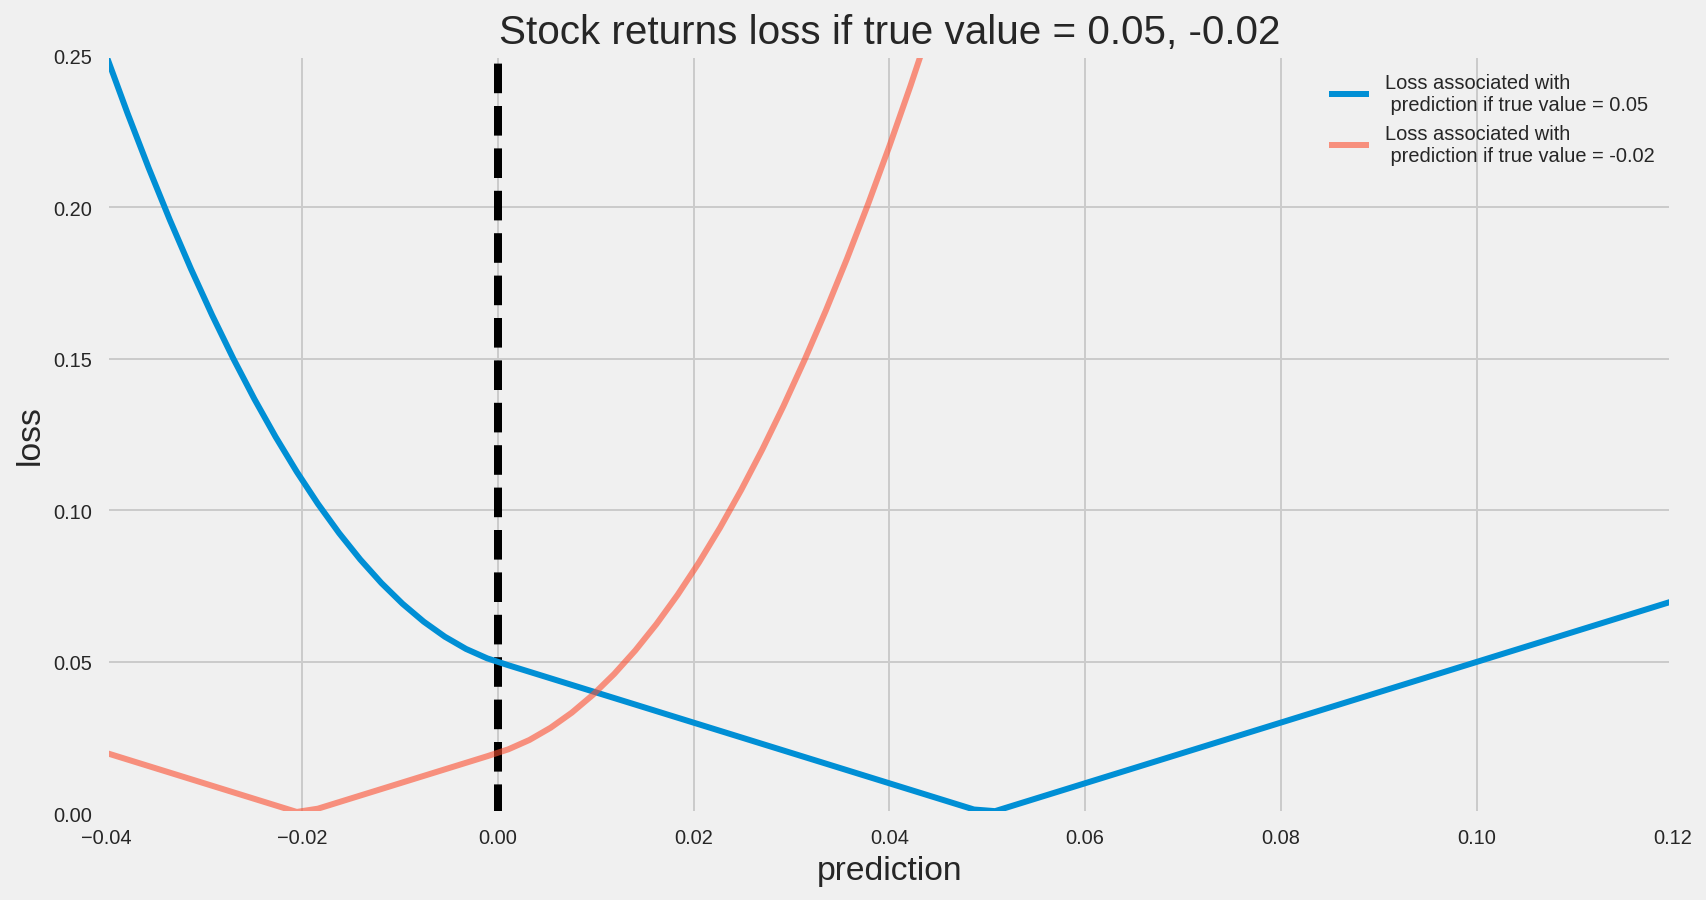

In [14]:
figsize(12.5, 6.5)

tf.reset_default_graph()


def stock_loss(true_return, yhat, alpha=100.):
    """
    Stock Loss function
    
    Args:
      true_return: float32
      yhat: float32
      alpha:float32
      
    Returns:
      float: absolute value of the difference
      between `true_return` and `yhat`
    """
    if true_return * yhat < 0:
        # opposite signs, not good
        return alpha * yhat ** 2 - np.sign(true_return) * yhat \
            + abs(true_return)
    else:
        return abs(true_return - yhat)


true_value = .05
pred = np.linspace(-.04, .12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred],
         label="Loss associated with\n prediction if true value = 0.05", lw=3)
plt.vlines(0, 0, .25, linestyles="--")

plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-0.04, .12)
plt.ylim(0, 0.25)

true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha=0.6,
         label="Loss associated with\n prediction if true value = -0.02", lw=3)
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02");


Note the change in the shape of the loss as the prediction crosses zero. This loss reflects that the user really does not want to guess the wrong sign, especially be wrong *and* a large magnitude. 

Why would the user care about the magnitude? Why is the loss not 0 for predicting the correct sign? Surely, if the return is 0.01 and we bet millions we will still be (very) happy.

Financial institutions treat downside risk, as in predicting a lot on the wrong side, and upside risk, as in predicting a lot on the right side, similarly. Both are seen as risky behaviour and discouraged. Hence why we have an increasing loss as we move further away from the true price. (With less extreme loss in the direction of the correct sign.)

We will perform a regression on a trading signal that we believe predicts future returns well. Our dataset is artificial, as most financial data is not even close to linear. Below, we plot the data along with the least-squares line.

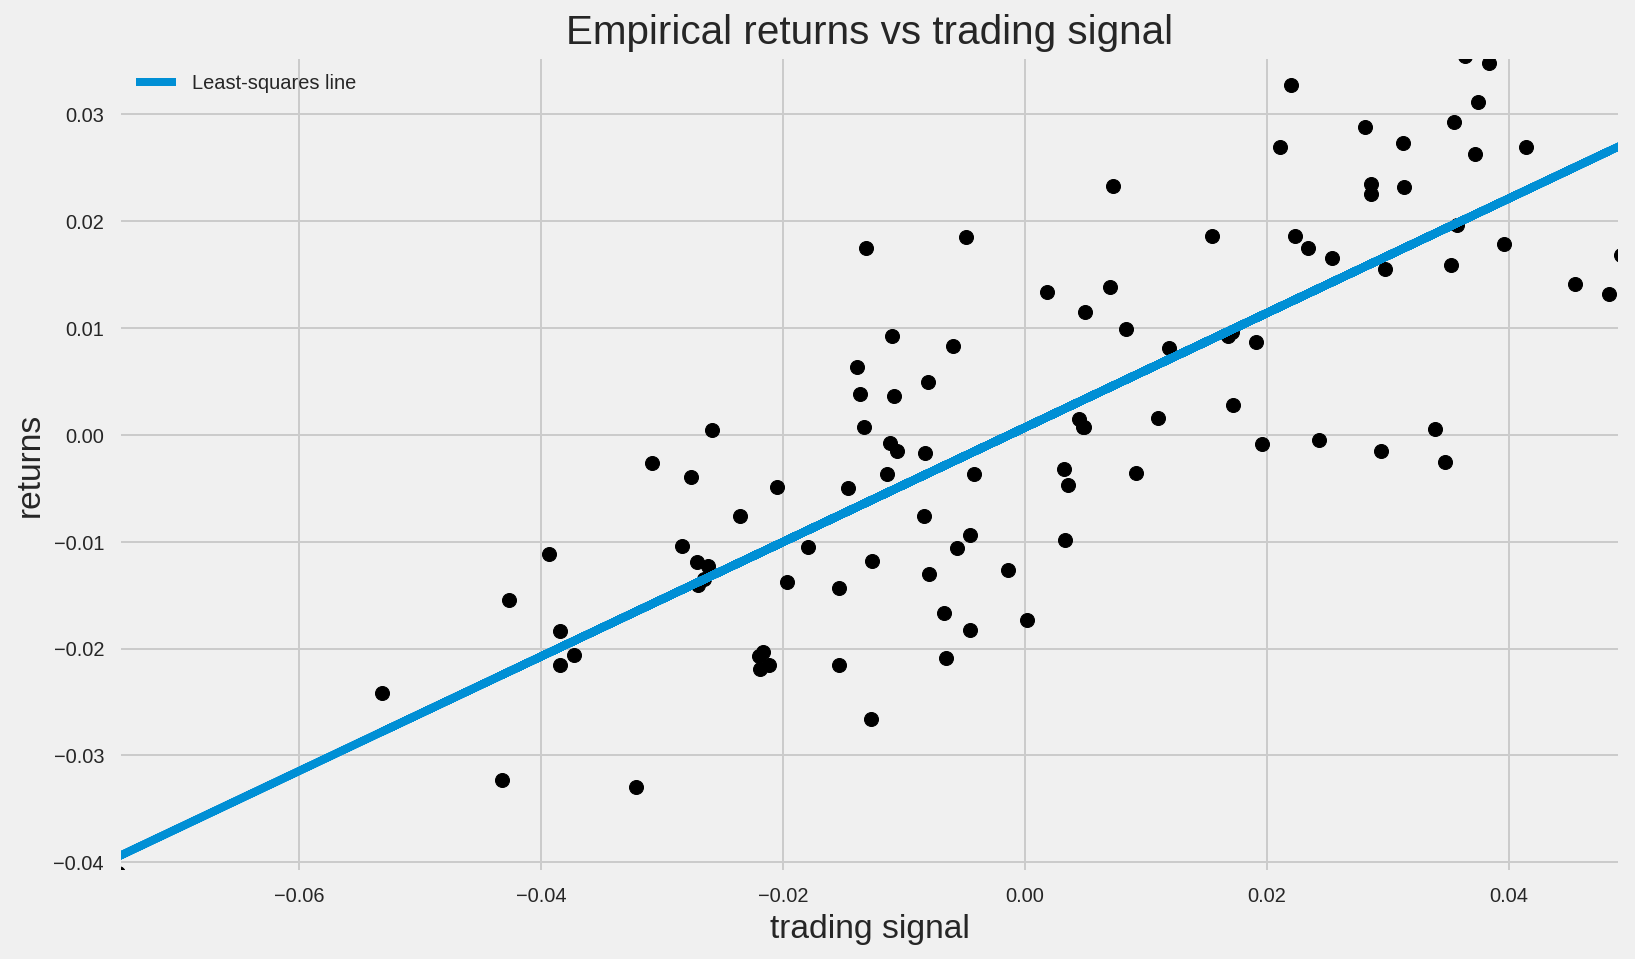

In [15]:
# Code for creating artificial "dummy" data
# This is a common strategy for testing our models
# before applying it to real-world data

tf.reset_default_graph()  # Resets the default tensorflow graph we're using

num_data = 100
X_data = np.float32(0.025 * np.random.randn(num_data))
Y_data = np.float32(0.5 * X_data + 0.01 * np.random.randn(num_data))

ls_coef_ = np.cov(X_data, Y_data)[0, 1] / np.var(X_data)
ls_intercept = Y_data.mean() - ls_coef_ * X_data.mean()

plt.figure(figsize=(12,7))
plt.scatter(X_data, Y_data, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X_data, ls_coef_ * X_data + ls_intercept, label="Least-squares line")
plt.xlim(X_data.min(), X_data.max())
plt.ylim(Y_data.min(), Y_data.max())
plt.legend(loc="upper left");


We perform a simple Bayesian linear regression on this dataset. We look for a model like:

$$ R = \alpha + \beta x + \epsilon$$

where $\alpha, \beta$ are our unknown parameters and $\epsilon \sim \text{Normal}(0, 1/\tau)$. The most common priors on $\beta$ and $\alpha$ are Normal priors. We will also assign a prior on $\tau$, so that $\sigma = 1/\sqrt{\tau}$ is uniform over 0 to 100 (equivalently then $\tau = 1/\text{Uniform}(0, 100)^2$).

In [0]:
def mvn(loc, scale, name='MVN'):
    """
    Creates a multivariate normal distribution using
    terms for the mean and standard deviation.
    
    Args:
      loc: Distribution parameter for mean.
      scale: Distribution parameter for standard deviation.
      name: Name of the distrubution (for use in the TF graph)
    Returns: 
      TensorFlow distribution object.
    """
    return tfd.Independent(tfd.Normal(loc, scale), reinterpreted_batch_ndims=1)


# Let's define the log probability of the bayesian regression function
def posterior_log_prob(alpha_, beta_, sigma_):
    """
    Our posterior log probability, as a function of states
    
    Args:
      alpha_: scalar, taken from state
      beta_: scalar, taken from state
      sigma_: scalar, taken from state
    Returns: 
      Scalar sum of log probabilities
    Closure over: Y_data, X_data
    """
    rv_sigma = tfd.Uniform(low=dtype(0.), high=dtype(100.), name='sigma')  # Assuming 1D Uniform prior
    
    obs_stdev = tf.sqrt(
        tf.reduce_mean(tf.squared_difference(Y_data, tf.reduce_mean(Y_data, axis=0)),
                      axis=0))
    
    rv_alpha = tfd.Normal(loc=dtype(0.), scale=dtype(.0001), name='alpha') # Assuming 1D normal prior    
    rv_beta = tfd.Normal(loc=dtype(0.), scale=dtype(.0001), name='beta')   # Assuming 1D normal prior
    rv_obs = mvn(loc=(alpha_ + (beta_ * dtype(X_data))), scale=obs_stdev, name='rv_obs')
    
    return (rv_obs.log_prob(dtype(Y_data)) +
            rv_alpha.log_prob(alpha_) +
            rv_beta.log_prob(beta_) +
            rv_sigma.log_prob(sigma_))
            # f(B,a,sigma | y) = f(B,a,sigma)*f(y|B,a,sigma)
            # When I remove what I believe are the f(B,a,sigma) terms, we get a wider distribution on the plots

In [0]:
financial_prediction_graph = tf.Graph()
with financial_prediction_graph.as_default():
    # Operations created in this scope will be added to the graph `financial_prediction_graph`
    
    num_results = tf.placeholder(dtype=tf.int32, name='num_results')
    num_burnin_steps = tf.placeholder(dtype=tf.int32, name='num_burnin_steps')

    [alpha_, beta_, sigma_], kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            tf.zeros([], name='init_alpha'),
            tf.zeros([], name='init_beta'),
            tf.ones([], name='init_sigma')
        ], 
        kernel=tfp.mcmc.RandomWalkMetropolis( #We will use a Random Walk Metropolis MCMC algorithm
            target_log_prob_fn=posterior_log_prob,
            seed=54),
        parallel_iterations = 1,
        name='Metropolis_sampling')
    
    
    # Some of the steps of the MCMC will involve just getting close to where the right answers are
    # so we get the samples random walk, and cut off the trial (or `burn_in`) steps    
    burned_alpha_samples = alpha_[num_burnin_steps:]
    burned_beta_samples = beta_[num_burnin_steps:]
    burned_sigma_samples = sigma_[num_burnin_steps:]
    
    alpha_mean = tf.reduce_mean(burned_alpha_samples, axis=0)
    alpha_stdev = tf.sqrt(
        tf.reduce_mean(tf.squared_difference(burned_alpha_samples, alpha_mean),
                      axis=0))
    beta_mean = tf.reduce_mean(burned_beta_samples, axis=0)
    beta_stdev = tf.sqrt(
        tf.reduce_mean(tf.squared_difference(burned_beta_samples, beta_mean),
                      axis=0))
    sigma_mean = tf.reduce_mean(burned_sigma_samples, axis=0)
    sigma_stdev = tf.sqrt(
        tf.reduce_mean(tf.squared_difference(burned_sigma_samples, sigma_mean),
                      axis=0))
    
    # Getting 50,000 samples from the approximate posterior distribution
    posterior_alpha_predictive_samples = tfd.Normal(loc=alpha_mean, 
                                                    scale=alpha_stdev, 
                                                    name='approx_alpha_posterior').sample(sample_shape=5000)
    posterior_beta_predictive_samples = tfd.Normal(loc=beta_mean, 
                                                   scale=beta_stdev, 
                                                   name='approx_beta_posterior').sample(sample_shape=5000)
    posterior_sigma_predictive_samples = tfd.Normal(loc=sigma_mean, 
                                                   scale=sigma_stdev, 
                                                   name='approx_prec_posterior').sample(sample_shape=5000)

    # Initializing our variables in `financial_prediction_graph`
    init = tf.global_variables_initializer()



Nice. Now we'll eval the result with a `tf.Session()` run and see if it matches our expectations.

In [0]:
config = tf.ConfigProto()
if tf.test.is_gpu_available() == True:
    config.gpu_options.allow_growth = True
else:
    config.gpu_options.allow_growth = False

with tf.Session(config=config, graph=financial_prediction_graph) as sess_2:
    # This session will run operations from `financial_prediction_graph`, the graph shown above
    # `sess.graph` provides access to the graph used in a 
    # tf.Session
    writer = tf.summary.FileWriter("logs", sess_2.graph)
    
    # options = tf.RunOptions()
    # options.output_partition_graphs = True
    # options.teace_level = tf.RunOptions.FULL_TRACE
    
    ### Define a container for the returned metadata
    #
    # metadata = tf.RunMetadata()
    
    # Running the Initializer on our model
    sess_2.run(init)
    
    # performing our computations
    [
        alpha_val,
        beta_val,
        sigma_val,
        burned_alpha_samples_val,
        burned_beta_samples_val,
        burned_sigma_samples_val,
        posterior_alpha_predictive_samples_val,
        posterior_beta_predictive_samples_val,
        posterior_sigma_predictive_samples_val
    ] = sess_2.run(fetches=[
                            alpha_,
                            beta_,
                            sigma_,
                            burned_alpha_samples,
                            burned_beta_samples,
                            burned_sigma_samples,
                            posterior_alpha_predictive_samples,
                            posterior_beta_predictive_samples,
                            posterior_sigma_predictive_samples
                           ], 
                   feed_dict={num_results: 50000,# 50000
                              num_burnin_steps: 10000}) # 10000
                   # options=options,
                   # run_metadata=metadata)
    
    ### Print the subgraphs that executed on each device
    #
    # print(metadata.partition_graphs)
    
    ### Print the timings of each operation tht executed
    #
    # print(metadata.step_stats)
    
    # Closing the summary writer for this session
    writer.close()


It appears the MCMC has converged so we may continue.

For a specific trading signal, call it $x$, the distribution of possible returns has the form:

$$R_i(x) =  \alpha_i + \beta_ix + \epsilon $$

where $\epsilon \sim \text{Normal}(0, 1/\tau_i) $ and $i$ indexes our posterior samples. We wish to find the solution to 

$$ \arg \min_{r} \;\;E_{R(x)}\left[ \; L(R(x), r) \; \right] $$

according to the loss given above. This $r$ is our Bayes action for trading signal $x$. Below we plot the Bayes action over different trading signals. What do you notice?


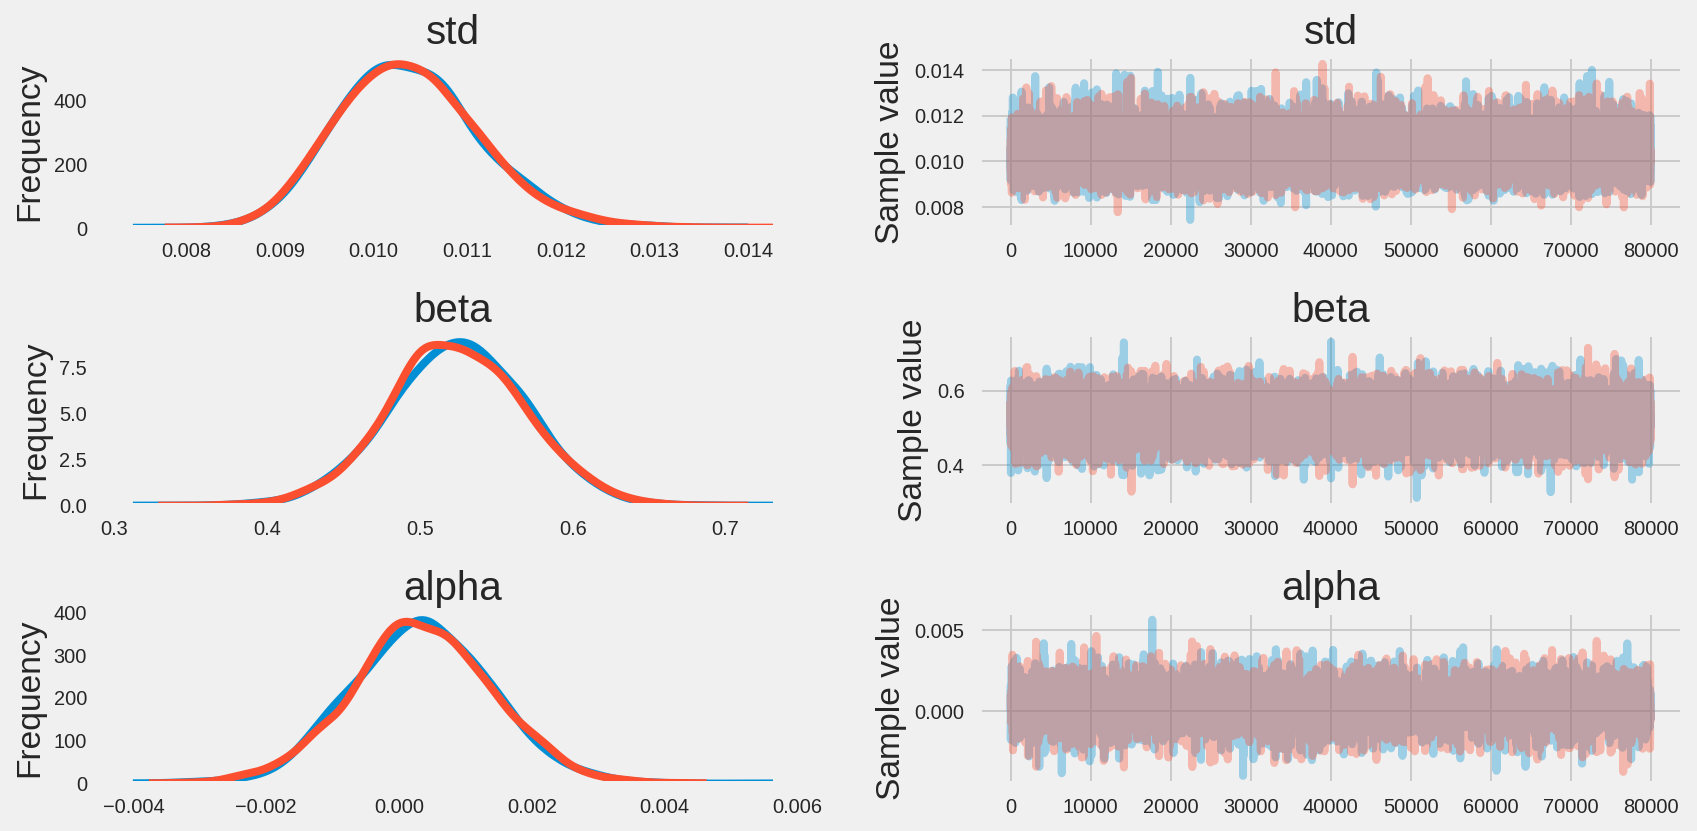

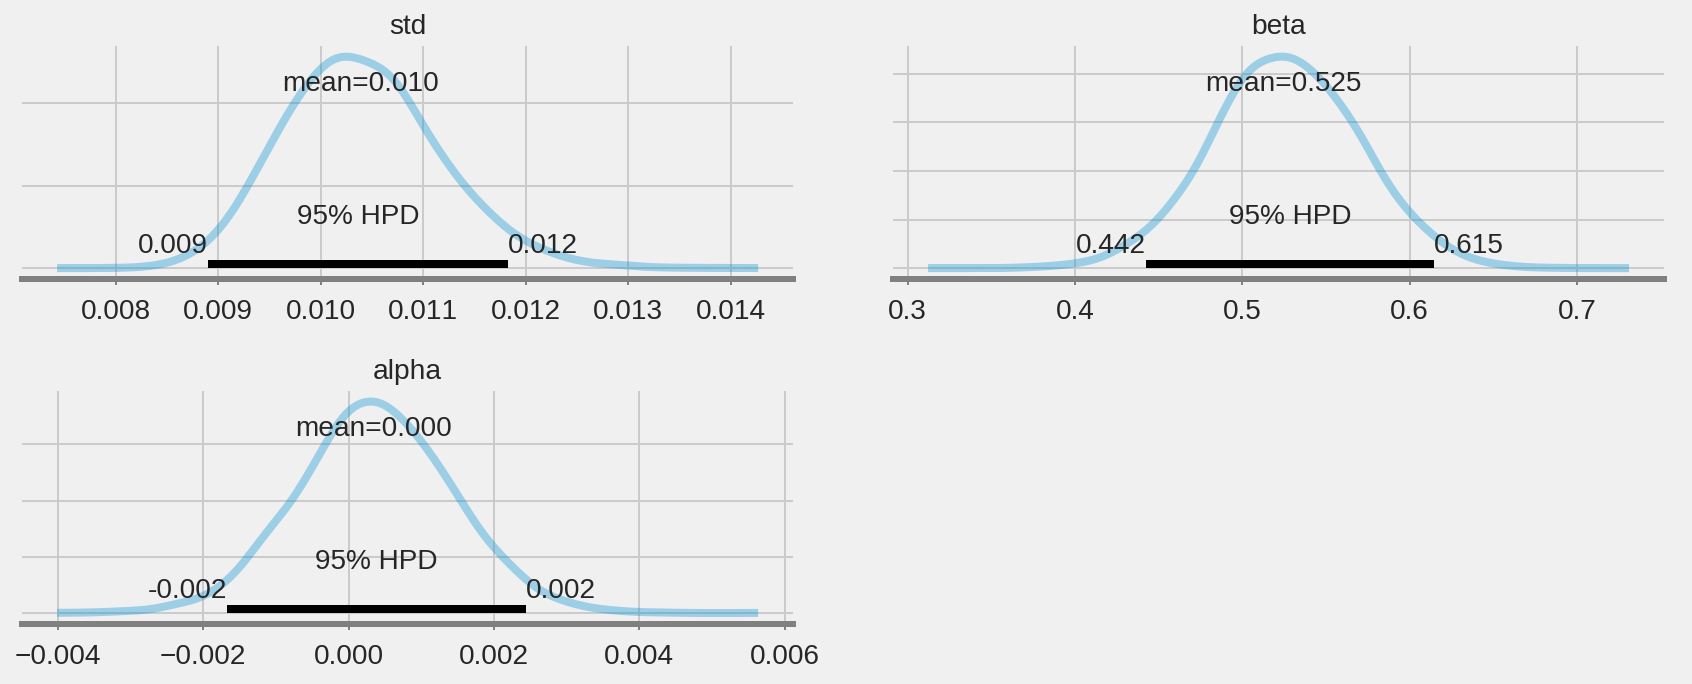

In [8]:
# We've added external python files used to plot the Frequency and Sample Variance
# of the outputs. You Don't need to run this cell.

import traceplot as traceplot
import plot_posterior as Plot_posterior

traceplot(trace=burned_trace, varnames=["std", "beta", "alpha"])
plot_posterior(trace=burned_trace, varnames=["std", "beta", "alpha"], kde_plot=True);

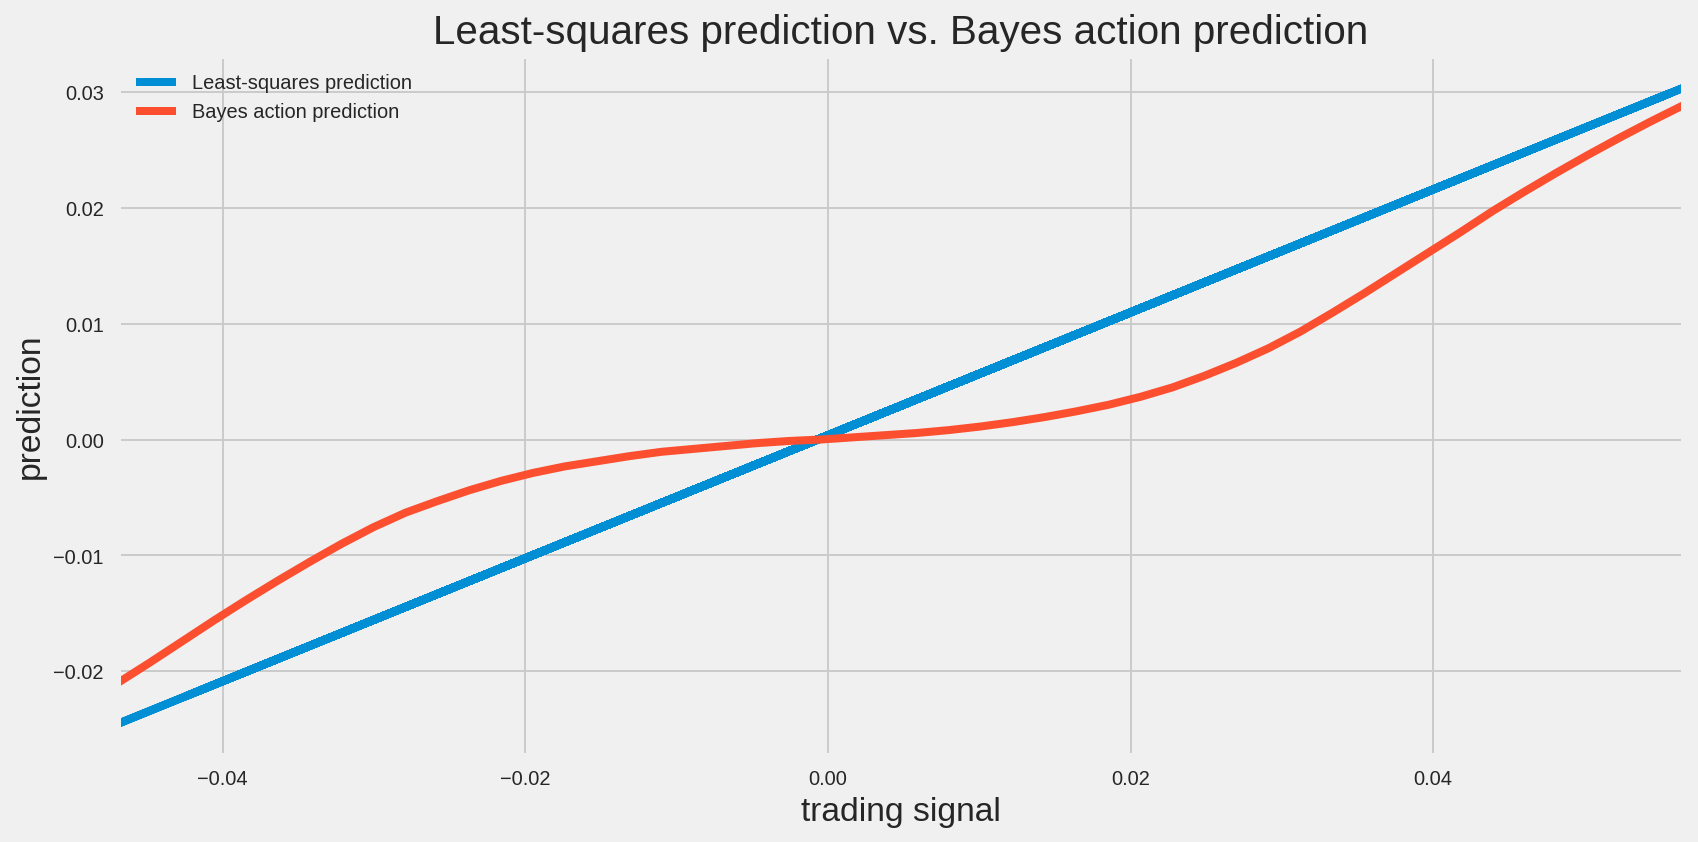

In [9]:
figsize(12.5, 6)
from scipy.optimize import fmin

def stock_loss(price, pred, coef=500):
    """
    Stock Loss function Vectorized for numpy
    
    Args:
      price: 
      pred: 
      coef: 
    Returns:
      sol: 
    """
    sol = np.zeros_like(price)
    ix = price * pred < 0
    sol[ix] = coef * pred ** 2 - np.sign(price[ix]) * pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol


N = posterior_sigma_predictive_samples_val.shape[0]

noise = N = posterior_sigma_predictive_samples_val.shape[0] * np.random.randn(N)

possible_outcomes = lambda signal: posterior_alpha_predictive_samples_val + \
                                   posterior_beta_predictive_samples_val * signal + \
                                   noise

opt_predictions = np.zeros(50)
trading_signals = np.linspace(X_data.min(), X_data.max(), 50)
for i, _signal in enumerate(trading_signals):
    _possible_outcomes = possible_outcomes(_signal)
    tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
    opt_predictions[i] = fmin(tomin, 0, disp=False)
    
    
plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X_data, ls_coef_ * X_data + ls_intercept, label="Least-squares prediction")
plt.xlim(X_data.min(), X_data.max())
plt.plot(trading_signals, opt_predictions, label="Bayes action prediction")
plt.legend(loc="upper left");


What is interesting about the above graph is that when the signal is near 0, and many of the possible  returns outcomes are possibly both positive and negative, our best (with respect to our loss) prediction is to predict close to 0, hence *take on no position*. Only when we are very confident do we enter into a position. I call this style of model a *sparse prediction*, where we feel uncomfortable with our uncertainty so choose not to act. (Compare with the least-squares prediction which will rarely, if ever, predict zero). 

A good sanity check that our model is still reasonable: as the signal becomes more and more extreme, and we feel more and more confident about the positive/negativeness of returns, our position converges with that of the least-squares line. 

The sparse-prediction model is not trying to *fit* the data the best (according to a *squared-error loss* definition of *fit*). That honor would go to the least-squares model. The sparse-prediction model is trying to find the best prediction *with respect to our `stock_loss`-defined loss*. We can turn this reasoning around: the least-squares model is not trying to *predict* the best (according to a *`stock-loss`* definition of *predict*). That honor would go the *sparse prediction* model. The least-squares model is trying to find the best fit of the data *with respect to the squared-error loss*.

# Example: Kaggle contest on *Observing Dark World*


A personal motivation for learning Bayesian methods was trying to piece together the winning solution to Kaggle's [*Observing Dark Worlds*](http://www.kaggle.com/c/DarkWorlds) contest. From the contest's website:



>There is more to the Universe than meets the eye. Out in the cosmos exists a form of matter that outnumbers the stuff we can see by almost 7 to 1, and we don’t know what it is. What we do know is that it does not emit or absorb light, so we call it Dark Matter. Such a vast amount of aggregated matter does not go unnoticed. In fact we observe that this stuff aggregates and forms massive structures called Dark Matter Halos. Although dark, it warps and bends spacetime such that any light from a background galaxy which passes close to the Dark Matter will have its path altered and changed. This bending causes the galaxy to appear as an ellipse in the sky.

<img src="http://timsalimans.com/wp-content/uploads/2012/12/dm.jpg" width = 730>


The contest required predictions about where dark matter was likely to be. The winner, [Tim Salimans](http://timsalimans.com/), used Bayesian inference to find the best locations for the halos (interestingly, the second-place winner also used Bayesian inference). With Tim's permission, we provided his solution [1] here:

1. Construct a prior distribution for the halo positions $p(x)$, i.e. formulate our expectations about the halo positions before looking at the data.
2. Construct a probabilistic model for the data (observed ellipticities of the galaxies) given the positions of the dark matter halos: $p(e | x)$.
3. Use Bayes’ rule to get the posterior distribution of the halo positions, i.e. use to the data to guess where the dark matter halos might be.
4. Minimize the expected loss with respect to the posterior distribution over the predictions for the halo positions: $\hat{x} = \arg \min_{\text{prediction} } E_{p(x|e)}[ L( \text{prediction}, x) ]$ , i.e. tune our predictions to be as good as possible for the given error metric.


The loss function in this problem is very complicated. For the very determined, the loss function is contained in the file DarkWorldsMetric.py in the parent folder. Though I suggest not reading it all, suffice to say the loss function is about 160 lines of code &mdash; not something that can be written down in a single mathematical line. The loss function attempts to measure the accuracy of prediction, in a Euclidean distance sense, such that no shift-bias is present. More details can be found on the metric's [main page](http://www.kaggle.com/c/DarkWorlds/details/evaluation). 

We will attempt to implement Tim's winning solution using [Tensorflow Probability](https://medium.com/tensorflow/introducing-tensorflow-probability-dca4c304e245) (full whitepaper [here](https://arxiv.org/pdf/1711.10604.pdf)) and our knowledge of loss functions.

### Setup

To get started with probabilistic machine learning in TensorFlow, just run the following in your terminal (make sure you have `pip` installed first):

```
pip install --upgrade tfp-nightly
```

Depending on the stability of the tfp-nightly releases, you might want to try the following first:

```
!pip install tb-nightly
!pip install tf-nightly
!pip install tfp-nightly
```

Of course, we also need to make sure the correct version of Tensorlfow (ideally 1.8) is installed as well. To do this, let's make sure any conflicting or out-of-date versions of `tensorflow`, `protobuf`, or `tf-nightly` are 

In [0]:
!pip3 install -q tfp-nightly

/bin/sh: pip: command not found


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))


Saving DarkWorldsMetric.py to DarkWorldsMetric.py
Saving data.zip to data.zip
Saving Gridded_Signal_benchmak.py to Gridded_Signal_benchmak.py
Saving Maximum_likelihood_Benchmark.py to Maximum_likelihood_Benchmark.py
Saving Random_Benchmark.py to Random_Benchmark.py
User uploaded file "DarkWorldsMetric.py" with length 20803 bytes
User uploaded file "data.zip" with length 4335351 bytes
User uploaded file "Gridded_Signal_benchmak.py" with length 5695 bytes
User uploaded file "Maximum_likelihood_Benchmark.py" with length 4498 bytes
User uploaded file "Random_Benchmark.py" with length 1903 bytes


In [0]:
!unzip data.zip -d data

Archive:  data.zip
   creating: data/Test_Skies/
  inflating: data/Test_Skies/Test_Sky1.csv  
  inflating: data/Test_Skies/Test_Sky10.csv  
  inflating: data/Test_Skies/Test_Sky100.csv  
  inflating: data/Test_Skies/Test_Sky101.csv  
  inflating: data/Test_Skies/Test_Sky102.csv  
  inflating: data/Test_Skies/Test_Sky103.csv  
  inflating: data/Test_Skies/Test_Sky104.csv  
  inflating: data/Test_Skies/Test_Sky105.csv  
  inflating: data/Test_Skies/Test_Sky106.csv  
  inflating: data/Test_Skies/Test_Sky107.csv  
  inflating: data/Test_Skies/Test_Sky108.csv  
  inflating: data/Test_Skies/Test_Sky109.csv  
  inflating: data/Test_Skies/Test_Sky11.csv  
  inflating: data/Test_Skies/Test_Sky110.csv  
  inflating: data/Test_Skies/Test_Sky111.csv  
  inflating: data/Test_Skies/Test_Sky112.csv  
  inflating: data/Test_Skies/Test_Sky113.csv  
  inflating: data/Test_Skies/Test_Sky114.csv  
  inflating: data/Test_Skies/Test_Sky115.csv  
  inflating: data/Test_Skies/Test_Sky116.csv  
  inflating: da

We also want to import the data files and Loss functions specific to this Kaggle Competition. You can download the files directly from the [Observing Dark Worlds competition's Data page](https://www.kaggle.com/c/DarkWorlds/data) or, if you already have a Kaggle account, install the [Kaggle API](https://github.com/Kaggle/kaggle-api) and run the following terminal command:

```
kaggle competitions download -c DarkWorlds
```

And once the competition information is available locally, we can simply unzip the data.


One last thing to set up is the function we use for plotting galaxies from the files, which we define here:

#### Defining our galaxy-plotting function

In [0]:
tf.reset_default_graph()  # Resets the default tensorflow graph we're using

def draw_sky(galaxies):
    """
    From a given file of galaxy data, 
    plots the shapes and positions of
    galaxies.
    
    Args:
      galaxies: 4-column, float32 Numpy array
      containing x-coordinates, y-coordinates,
      and the two axes of ellipcity.
    Returns:
      fig: image of galaxy plot
    """
    size_multiplier = 45
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i,:]
        x, y = _g[0], _g[1]
        d = np.sqrt(_g[2] ** 2 + _g[3] ** 2)
        a = 1.0 / (1 - d)
        b = 1.0 / (1 + d)
        theta = np.degrees( np.arctan2( _g[3], _g[2])*0.5 )
        
        ax.add_patch(Ellipse(xy=(x, y), width=size_multiplier * a, height=size_multiplier * b, angle=theta))
    ax.autoscale_view(tight=True)
    
    return fig


### Examining Our Data

The dataset is actually 300 separate files, each representing a sky. In each file, or sky, are between 300 and 720 galaxies. Each galaxy has an $x$ and $y$ position associated with it, ranging from 0 to 4200, and measures of ellipticity: $e_1$ and $e_2$. Information about what these measures mean can be found [here](https://www.kaggle.com/c/DarkWorlds/details/an-introduction-to-ellipticity), but for our purposes it does not matter besides for visualization purposes. Thus a typical sky might look like the following:

In [0]:
tf.reset_default_graph()  # Resets the default tensorflow graph we're using

n_sky = 3             #choose a file/sky to examine.
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = np.float32,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])
              # It's handy to specify the data type beforehand

galaxy_positions = np.array(data[:, :2], dtype=np.float32)
gal_ellipticities = np.array(data[:, 2:], dtype=np.float32)
ellipticity_mean = np.mean(data[:, 2:], axis=0)
ellipticity_stddev = np.std(data[:, 2:], axis=0)
num_galaxies = np.array(galaxy_positions).shape[0]

print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])
print("Number of Galaxies: ", num_galaxies)
print("e_1 & e_2 mean: ", ellipticity_mean)
print("e_1 & e_2 std_dev: ", ellipticity_stddev)


Data on galaxies in sky 3.
position_x, position_y, e_1, e_2 
[[ 1.62690e+02  1.60006e+03  1.14664e-01 -1.90326e-01]
 [ 2.27228e+03  5.40040e+02  6.23555e-01  2.14979e-01]
 [ 3.55364e+03  2.69771e+03  2.83527e-01 -3.01870e-01]]
Number of Galaxies:  578
e_1 & e_2 mean:  [ 0.01398942 -0.00522833]
e_1 & e_2 std_dev:  [0.23272723 0.22050022]


Nice, as we can see above we have the data organized into columns according to their x and y coordinates, and the degrees of elipticity along each axis of the galaxies. If we want to reference the positions directly, we can use the following:

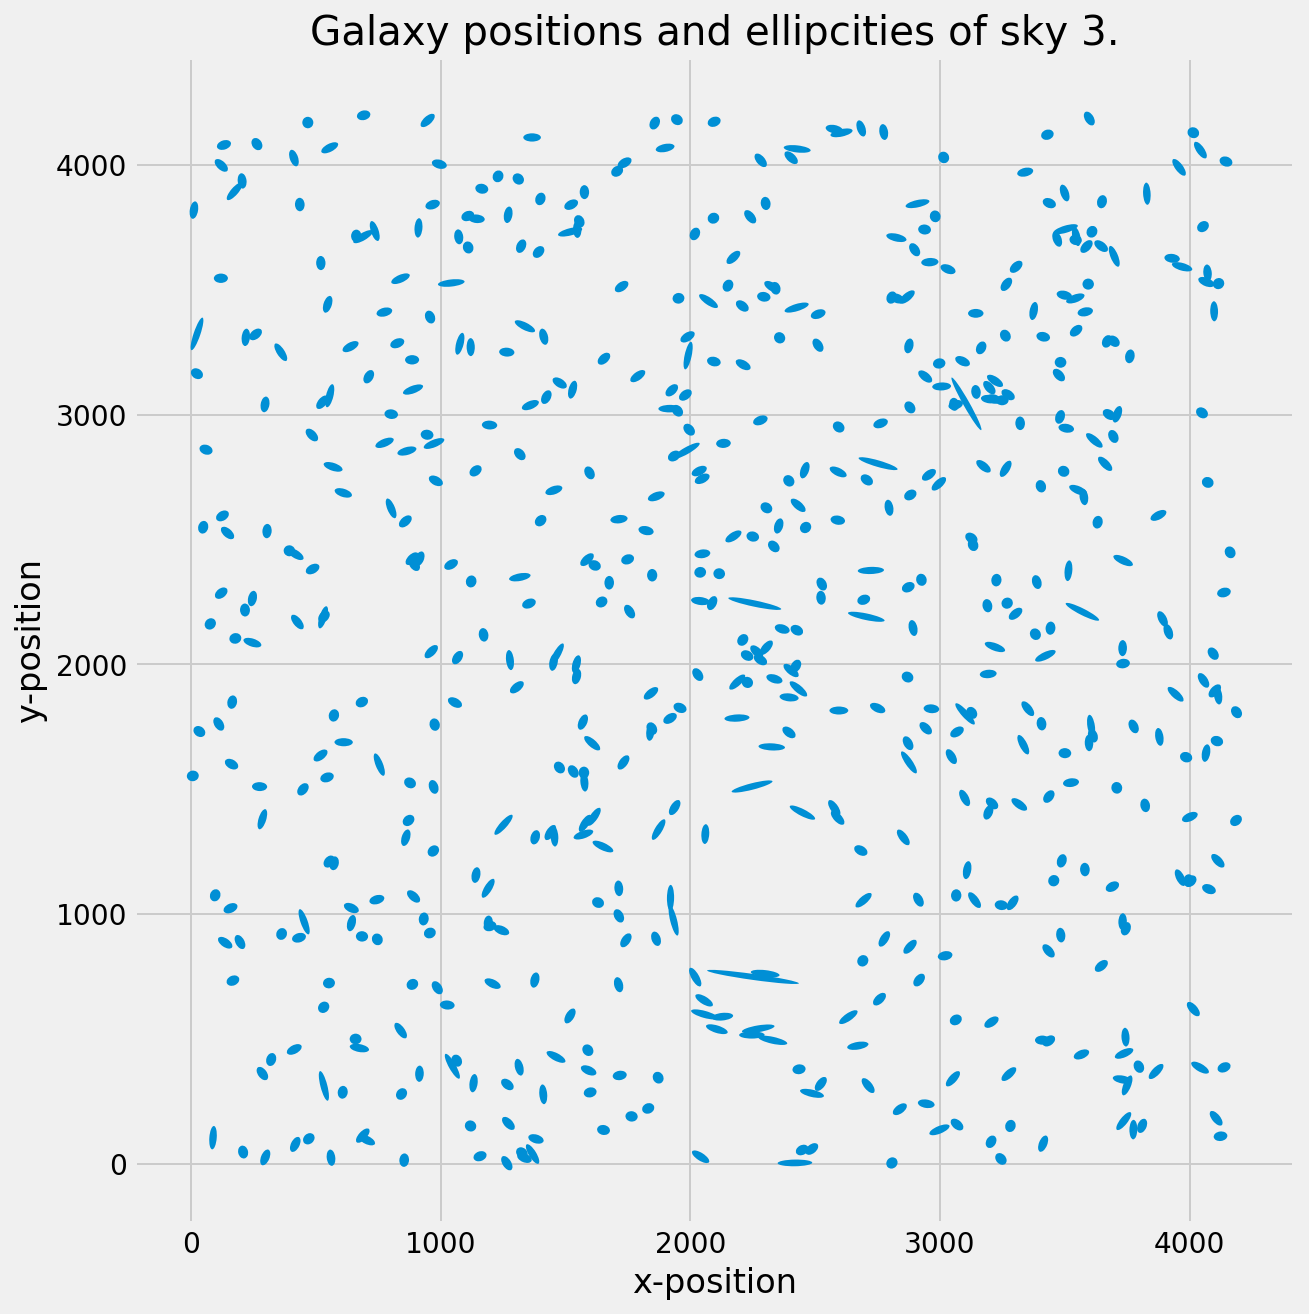

In [0]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position");



...beautiful!


### Priors

Each sky has one, two or three dark matter halos in it. Tim's solution details that his prior distribution of halo positions was uniform, i.e.

\begin{align}
& x_i \sim \text{Uniform}( 0, 4200)\\\\
& y_i \sim \text{Uniform}( 0, 4200), \;\; i=1,2,3\\\\
\end{align}

Tim and other competitors noted that most skies had one large halo and other halos, if present, were much smaller. Larger halos, having more mass, will influence the surrounding galaxies more. He decided that the large halos would have a mass distributed as a *log*-uniform random variable between 40 and 180 i.e.

$$  m_{\text{large} } = \log \text{Uniform}( 40, 180 ) $$

and in Tensorflow Probability, 

```python
# Log-Uniform Distribution
mass_large = tfd.TransformedDistribution(
    distribution=tfd.Uniform(name="exp_mass_large", low=40.0, high=180.0),
    bijector=tfb.Exp())
```

(This is what we mean when we say *log*-uniform.) For smaller galaxies, Tim set the mass to be the logarithm of 20. Why did Tim not create a prior for the smaller mass, nor treat it as a unknown? I believe this decision was made to speed up convergence of the algorithm. This is not too restrictive, as by construction the smaller halos have less influence on the galaxies.

Tim logically assumed that the ellipticity of each galaxy is dependent on the position of the halos, the distance between the galaxy and halo, and the mass of the halos. Thus the vector of ellipticity of each galaxy, $\mathbf{e}_i$, are *children* variables of the vector of halo positions $(\mathbf{x},\mathbf{y})$, distance (which we will formalize), and halo masses.

Tim conceived a relationship to connect positions and ellipticity by reading literature and forum posts. He supposed the following was a reasonable relationship:

$$ e_i | ( \mathbf{x}, \mathbf{y} ) \sim \text{Normal}( \sum_{j = \text{halo positions} }d_{i,j} m_j f( r_{i,j} ), \sigma^2 ) $$

where $d_{i,j}$ is the *tangential direction* (the direction in which halo $j$ bends the light of galaxy $i$), $m_j$ is the mass of halo $j$, $f(r_{i,j})$ is a *decreasing function* of the Euclidean distance between halo $j$ and galaxy $i$. 

The variance, or $\sigma^2$, was simply estimated to be 0.05 from eyeballing the data. This means the Standard deviation (SD) of the measurement of $e_i$ for the full range of $i$ works out to approximately 0.223607......

Tim's function $f$ was defined:

$$ f( r_{i,j} ) = \frac{1}{\min( r_{i,j}, 240 ) } $$

for large halos, and for small halos

$$ f( r_{i,j} ) = \frac{1}{\min( r_{i,j}, 70 ) } $$

This fully bridges our observations and unknown. This model is incredibly simple, and Tim mentions this simplicity was purposefully designed: it prevents the model from overfitting.  


### Training & Tensorflow implementation

For each sky, we run our Bayesian model to find the posteriors for the halo positions &mdash; we ignore the (known) halo position. This is slightly different than perhaps traditional approaches to Kaggle competitions, where this model uses no data from other skies nor the known halo location. That does not mean other data are not necessary &mdash; in fact, the model was created by comparing different skies. 

##### Constructing a prior distribution for the halo positions $p(x)$, i.e. formulate our expectations about the halo positions before looking at the data.

When constructing our prior and likelihood distributions, we're going to use these to set up a loss function that is very similar to that of a [Variational Auto Encoder](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/vae.py) (although a much lower-dimensional one).

In [0]:
def euclidean_distance(x, y):
    """
    Calculates the euclidian distance between
    point x and poin y.
    
    Args:
      x: a Tensorflow tensor for element-wise
      calculation
      y: a Tensorflow tensor for element-wise
      calculation
    Returns: 
      a Tensor containing the euclidian 
      distance between x and y
    """
    return tf.sqrt(tf.reduce_sum(tf.squared_difference(x, y), axis=1), name="euclid_dist")


def f_distance(gxy_pos, halo_pos, c):
    """
    Provides our element-wise maximum as in NumPy, 
    but instead for TensorFlow tensors
    
    Args:
      gxy_pos: a 2-d numpy array of observed galaxy
        positions
      halo_pos: a 2-d numpy array with halo positions
      c: a scalar of shape order 0
    Returns: 
      Maximum of either the uclidian distance of gxy_pos
      & halo_pos, or the constant c.
    """
    return tf.maximum(euclidean_distance(gxy_pos, halo_pos), c, name="f_dist")[:, None]


def tangential_distance(glxy_position, halo_position):
    """
    Calculates the tangential distance between
    coordinates glxy_position & halo_position.
    
    Args:
      glxy_position: a 2-d numpy array of observed galaxy
        positions
      halo_position: a 2-d numpy array with halo positions
    Returns: 
      vectors with direction of dominant halo.
    """
    
    x_delta, y_delta = tf.unstack(
    glxy_position - halo_position, num=2, axis=-1)
    angle = 2. * tf.atan(y_delta / x_delta)
    return tf.stack([-tf.cos(angle), -tf.sin(angle)], axis=-1, name='tan_dist')


In [0]:
def mvn(loc, scale, name='MVN'):
    """
    Creates a multivariate normal distribution using
    terms for the mean and standard deviation.
    
    Args:
      loc: Distribution parameter for mean.
      scale: Distribution parameter for standard deviation.
      name: Name of the distrubution (for use in the TF graph)
    Returns: 
      TensorFlow distribution object.
    """
    return tfd.Independent(tfd.Normal(loc, scale), reinterpreted_batch_ndims=1, name=name)


def posterior_log_prob(mass_large_, halo_pos_):
    """
    Our posterior log probability, as a function of states
    Closure over: data
    
    Args:
      mass_large_: scalar of halo mass, taken from state
      halo_pos_: tensor of halo position(s), taken from state
    Returns: 
      Scalar sum of log probabilities
    """
    rv_mass_large = tfd.Uniform(name='rv_mass_large', low=40., high=180.)    
    
    #set the random size of the halo's mass (the big halo for now)
    rv_halo_pos = tfd.Independent(tfd.Uniform(
                                       low=[0., 0.],
                                       high=[4200., 4200.]),
                           reinterpreted_batch_ndims=1, name='rv_halo_position')
    
    ellpty = mvn(loc=(mass_large_ /
              f_distance(data[:, :2], halo_pos_, 240.) *
              tangential_distance(data[:, :2], halo_pos_)), 
                 scale=0.223607,
                 name='ellpty')
    
    return (tf.reduce_sum(ellpty.log_prob(data[:, 2:]), axis=0) + 
            rv_halo_pos.log_prob(halo_pos_) + 
            rv_mass_large.log_prob(mass_large_))


Let's go onto the next part:

#### Constructing a probabilistic model for the data (observed ellipticities of the galaxies) given the positions of the dark matter halos: $p(e | x)$.

Given data, we use a Metropolis Random Walk (MRW) Markov chain Monte Carlo method to calculate the precise posterior distribution over the model's parameters. It is possible to use Hamiltoniam Monte Carlo (HMC) for problems like this, but Metropolis is more appropriate for this case due to it's comparative simplicity.

Tim's model gives us an approximate posterior to start with. That is, we asume the posterior must be proportional to the normal distribution of distances inferred from galaxy ellipcities.


In [0]:
# Inferring the posterior distribution

g_3 = tf.Graph()
with g_3.as_default():
    # Operations created in this scope will be added to the graph `g_3`

    num_results = tf.placeholder(dtype=tf.int32, name='num_results')
    num_burnin_steps = tf.placeholder(dtype=tf.int32, name='num_burnin_steps')

    [mass_large, halo_pos], kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            tf.fill([1], 80.),
            tf.fill([1, 2], 2100.)
        ],
        kernel=tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=posterior_log_prob,
            seed=54),
        parallel_iterations = 5,
        name='MAP_eval')


We new have the setup for our probabilistic model. We can now go onto the third step:


#### Using Bayes’ rule to get the posterior distribution of the halo positions, i.e. use to the data to guess where the dark matter halos might be.

We're going to take the results of the outputs of the Markov chain, take the mean and standard deviation, and then use those to create a lower-dimensional multivariate normal distribution of halo distributions. This will be our posterior predictive distribution.

First, we can create the convenience functions to set up our session

In [0]:
with g_3.as_default():
    # Operations created in this scope will be added to the graph `g_3`
    [
        mass_large_,
        halo_pos_,
        is_accepted_
    ] = [
        mass_large,
        halo_pos,
        kernel_results.is_accepted
    ]

    # Some of the steps of the MCMC will involve just getting close to where the right answers are
    # so we get the samples random walk, and cut off the trial (or `burn_in`) steps    
    burned_halo_position_samples = tf.stack(tf.map_fn(lambda x: x[0], halo_pos_), axis=0)[num_burnin_steps:]
    
    # we'll take the mean and standard deviations of the samples to put
    # together the approximate posterior distribution for the large halo    
    halo_mean = tf.reduce_mean(burned_halo_position_samples, axis=0)
    halo_stdev = tf.sqrt(
        tf.reduce_mean(tf.squared_difference(burned_halo_position_samples, halo_mean),
                      axis=0))

    approx_posterior = mvn(loc=halo_mean, scale=halo_stdev, name='approx_posterior')
    
    # Getting 50,000 samples from the approximate posterior distribution
    posterior_predictive_samples = approx_posterior.sample(sample_shape=50000)

    # Initializing our variables in `g_1`
    init = tf.global_variables_initializer()


We now have our graph all constructed. Now as we'll see before, we can use Either Tensorflow or GraphViz to display our graph of the workflow. First, we have GraphViz:


Now we'll eval the results with a `tf.Session()` run and see if it matches our expectations.

In [0]:
with tf.Session(config=config, graph=g_3) as sess_1:
    # This session will run operations from `g_1`
    # `sess.graph` provides access to the graph used in a 
    # tf.Session.
    writer = tf.summary.FileWriter("logs", sess_1.graph)
    
    ### Define options for the `sess.run()` call
    #
    # options = tf.RunOptions()
    # options.output_partition_graphs = True
    # options.trace_level = tf.RunOptions.FULL_TRACE
    
    ### Define a container for the returned metadata
    #
    # metadata = tf.RunMetadata()
    
    # Running the Initializer on our model
    sess_1.run(init)
    
    # Performing our computations
    # We use the `feed_dict` to give precise values to our MCMC parameters
    posterior_predictive_samples_val = sess_1.run(fetches=posterior_predictive_samples, 
                                                  feed_dict={num_results: 200000,
                                                             num_burnin_steps: 140000})
    
    ### Print the subgraphs that executed on each device
    # 
    # print(metadata.partition_graphs)
    
    ### Print the timings of each operation tht executed
    #
    # print(metadata.step_stats)
    
    # Closing the summary writer for this session
    writer.close()


Below we plot a "heatmap" of the posterior predictive distribution. (Which is just a scatter plot of the posterior, but we can visualize it as a heatmap.)

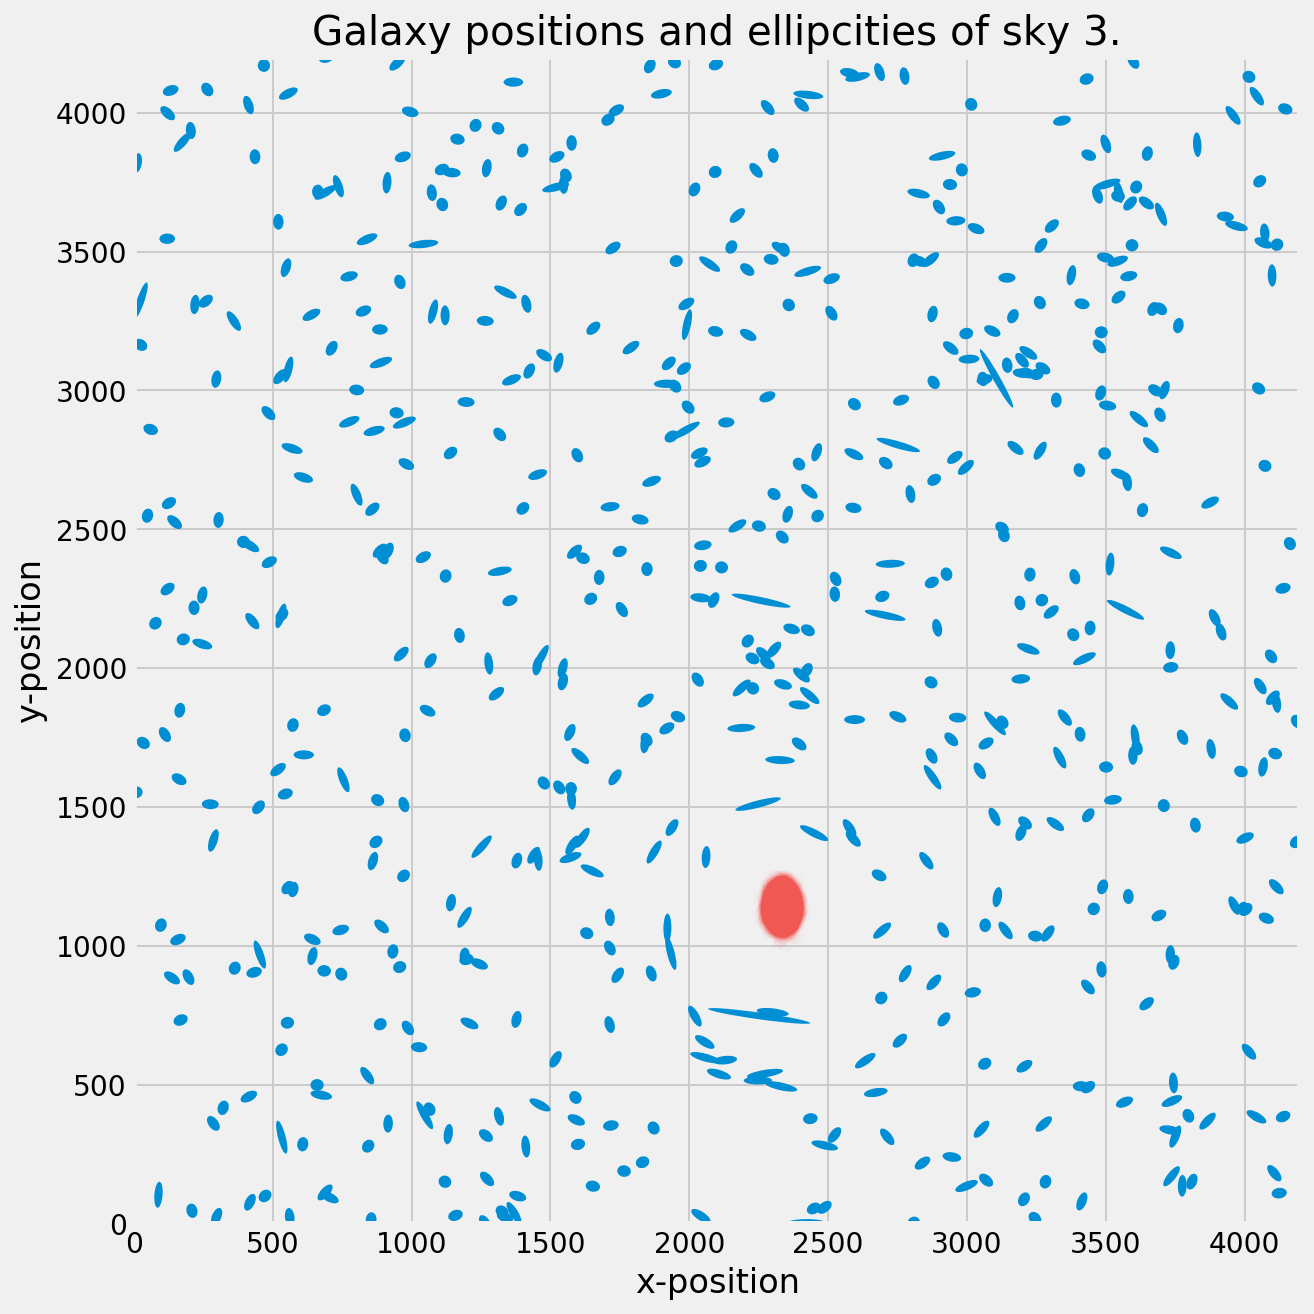

In [0]:
t = posterior_predictive_samples_val.reshape(50000,2)

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "#F15854") # Red
plt.xlim(0, 4200)
plt.ylim(0, 4200);


The most probable position reveals itself like a lethal wound.

Associated with each sky is another data point, located in `./data/Training_halos.csv` that holds the locations of up to three dark matter halos contained in the sky. For example, the night sky we trained on has halo locations:

In [0]:
halo_data = np.genfromtxt("data/Training_halos.csv", 
                          delimiter = ",",
                          usecols = [1, 2,3, 4,5,6,7,8,9],
                          skip_header = 1)
print(halo_data[n_sky])


[1.00000e+00 1.40861e+03 1.68586e+03 1.40861e+03 1.68586e+03 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]


The third and fourth column represent the true x and y position of the halo. It appears that the Bayesian method has located the halo within a tight vicinity.

True halo location: 1408.61 1685.86


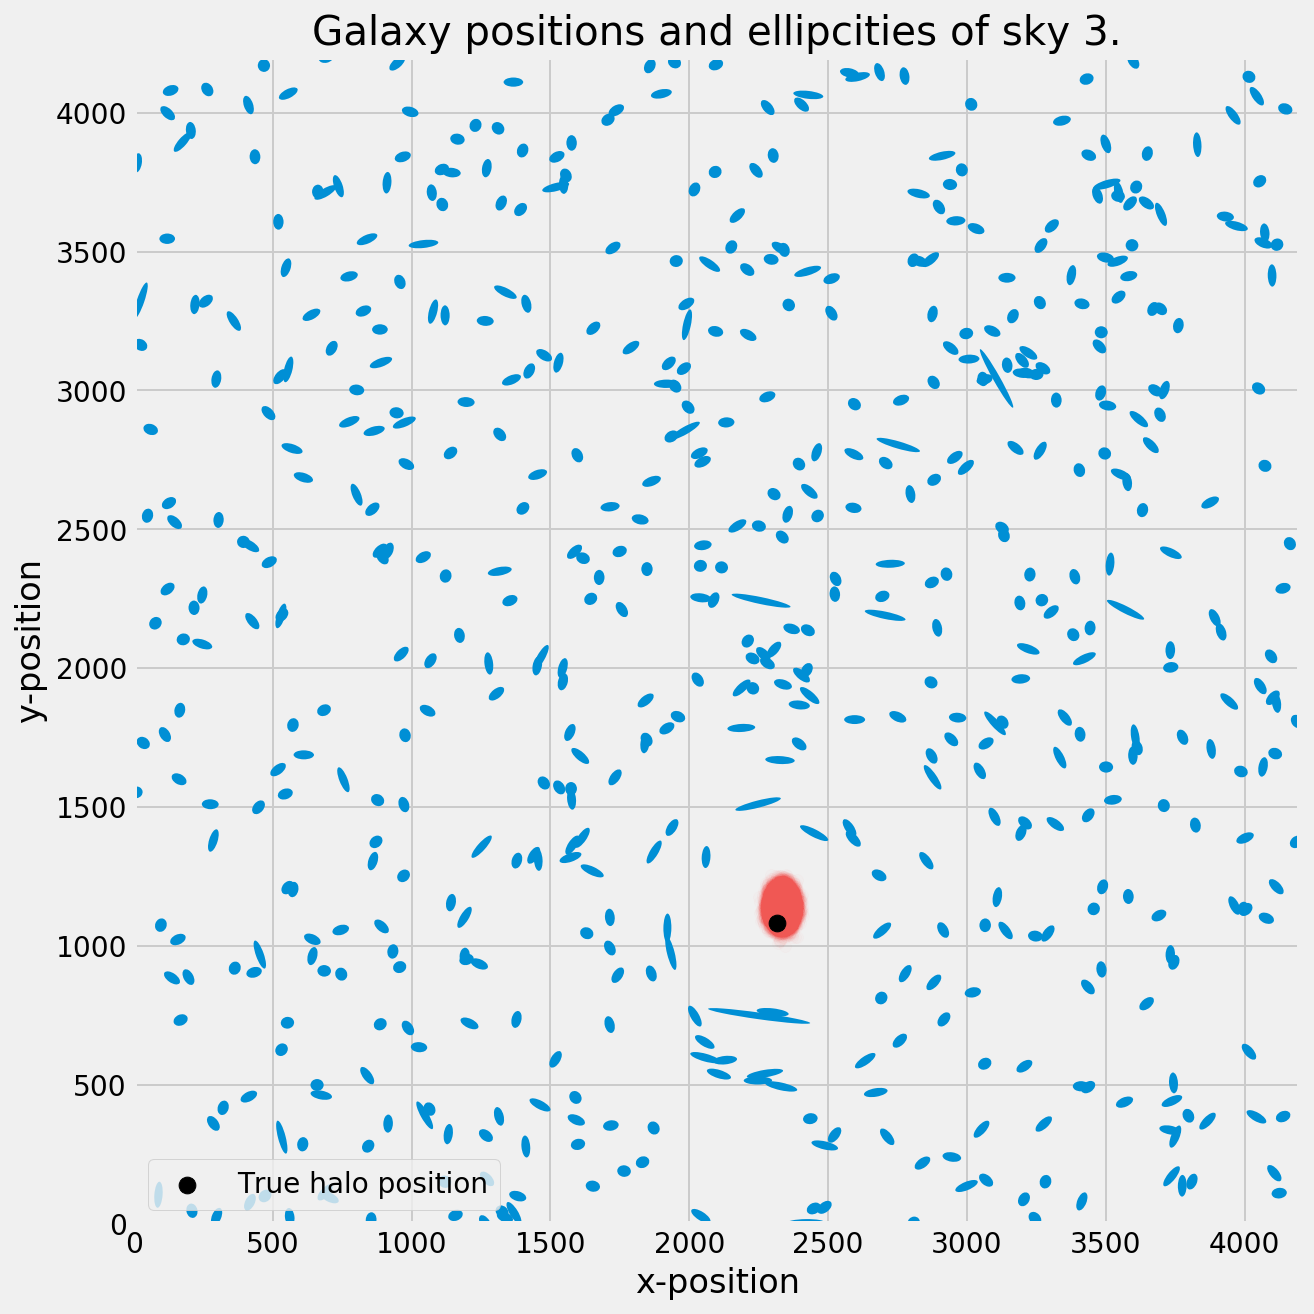

In [0]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "#F15854") # Red
plt.scatter(halo_data[n_sky-1][3], halo_data[n_sky-1][4], 
            label = "True halo position",
            c = "k", s = 70)
plt.legend(scatterpoints = 1, loc = "lower left")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

print("True halo location:", halo_data[n_sky][3], halo_data[n_sky][4])


Perfect. Our next step is to use the loss function to optimize our location. A naive strategy would be to simply choose the mean:

In [0]:
mean_posterior = t.mean(axis=0).reshape(1,2)
print(mean_posterior)


[[2332.2932 1140.8036]]


In [0]:
from DarkWorldsMetric import main_score

_halo_data = halo_data[n_sky-1]

nhalo_all =  _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior

print("Using the mean:")
main_score(nhalo_all, x_true_all, y_true_all,
            x_ref_all, y_ref_all, sky_prediction)

#what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1,2))
print("Using a random location:", random_guess)
main_score(nhalo_all, x_true_all, y_true_all,
            x_ref_all, y_ref_all, random_guess)


Using the mean:
Your average distance in pixels you are away from the true halo is 61.12635374794597
Your average angular vector is 1.0
Your score for the training data is 1.061126353747946
Using a random location: [[3850 2361]]
Your average distance in pixels you are away from the true halo is 1997.4483499955634
Your average angular vector is 1.0
Your score for the training data is 2.9974483499955635


2.9974483499955635

This is a good guess, it is not very far from the true location, but it ignores the loss function that was provided to us. We also need to extend our code to allow for up to two additional, *smaller* halos: Let's create a function for automatizing our Tensorflow workflow from before. 

First let's reset our Tensorflow Graph and import the new dataset:


In [0]:
reset_sess()     # Our custom function from before

n_sky = 215             #choosing a file/sky to examine.
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = np.float32,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])
              # It's handy to specify the data type beforehand

galaxy_positions = np.array(data[:, :2], dtype=np.float32)
gal_ellipticities = np.array(data[:, 2:], dtype=np.float32)
ellipticity_mean = np.mean(data[:, 2:], axis=0)
ellipticity_stddev = np.std(data[:, 2:], axis=0)
num_galaxies = np.array(galaxy_positions).shape[0]

print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])
print("Number of Galaxies: ", num_galaxies)
print("e_1 & e_2 mean: ", ellipticity_mean)
print("e_1 & e_2 std_dev: ", ellipticity_stddev)


Data on galaxies in sky 215.
position_x, position_y, e_1, e_2 
[[ 3.90340e+03  1.38480e+03 -4.93760e-02  1.73814e-01]
 [ 1.75626e+03  1.64510e+03  4.09440e-02  1.90665e-01]
 [ 3.81832e+03  3.18108e+03  1.97530e-01 -2.10599e-01]]
Number of Galaxies:  449
e_1 & e_2 mean:  [ 0.01484613 -0.02457484]
e_1 & e_2 std_dev:  [0.20280695 0.20415685]


In [0]:
def posterior_log_prob(mass_large_, halo_pos_):
    """
    Our modified posterior log probability, as a function of states
    Closure over: data
    
    Args:
      mass_large_: scalar of halo mass, taken from state
      halo_pos_: tensor of halo position(s), taken from state
    Closure over: 
      data
    Returns: 
      Scalar sum of log probabilities
    """
    # set the random size of the halo's mass (we have multiple)
    rv_mass_large = tfd.Uniform(name='rv_mass_large', low=dtype(40.), high=dtype(180.))    

    rv_mass_small_1 = dtype(20.)
    rv_mass_small_2 = dtype(20.)
        
    masses = np.array([mass_large_, rv_mass_small_1, rv_mass_small_2], dtype=object)
     
    # set the initial prior positions of the halos, 
    # these are a set of 2-d Uniform distributions

    rv_halo_pos = tfd.Independent(tfd.Uniform(name="rv_halo_positions",
                                         low=np.reshape(
                                             np.tile([dtype(0.), dtype(0.)],
                                                     n_halos_in_sky),
                                             [n_halos_in_sky, 2]),
                                         high=np.reshape(
                                             np.tile([dtype(4200.), dtype(4200.)],
                                                     n_halos_in_sky),
                                             [n_halos_in_sky, 2])),
                             reinterpreted_batch_ndims=1) # notice this size
      
    fdist_constants = np.array([240., 70., 70.])
       
    # For our calculations of ellipcity derived from halo position, we derive means based
    # on the sum of the means of forces from multiple halos
        
    mean_sum = 0
    mean_sum += (mass_large_[0] / f_distance(data[:,:2], halo_pos_[0, :], fdist_constants[0]) *
            tangential_distance(data[:,:2], halo_pos_[0, :]))
    mean_sum += (rv_mass_small_1 / f_distance(data[:,:2], halo_pos_[1, :], fdist_constants[1]) *
            tangential_distance(data[:,:2], halo_pos_[1, :]))
    mean_sum += (rv_mass_small_2 / f_distance(data[:,:2], halo_pos_[2, :], fdist_constants[2]) *
            tangential_distance(data[:,:2], halo_pos_[2, :]))
        
    ellpty = mvn(loc=(mean_sum), scale=0.223607, name='ellpty')

    return (tf.reduce_sum(ellpty.log_prob(data[:, 2:]), axis=0) + 
            rv_halo_pos.log_prob(halo_pos_[0, :])[0] + 
            rv_halo_pos.log_prob(halo_pos_[1, :])[1] +
            rv_halo_pos.log_prob(halo_pos_[2, :])[2] + 
            rv_mass_large.log_prob(mass_large_[0][0]))


In [0]:
# Inferring the posterior distribution
g_4 = tf.Graph()
with g_4.as_default():
    # Operations created in this scope will be added to the graph `g_4`
    # We will define `num_results` and `num_burnin_steps` as placehloder tensors
    # so we can easily tune the input parameters without having to rebuild the 
    # graph each timegraph without having to rebuild it each time
    num_results = tf.placeholder(dtype=tf.int32, name='num_results')
    num_burnin_steps = tf.placeholder(dtype=tf.int32, name='num_burnin_steps')
    
    # We have three halos in the sky instead of one
    n_halos_in_sky = 3

    [mass_large, halo_pos], kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            tf.constant([80., 20., 20.], shape=[n_halos_in_sky,1]),
            tf.constant([1000., 1000., 2100., 2100., 3500., 3500.], shape=[n_halos_in_sky,2])
        ],
        kernel=tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=posterior_log_prob,
            seed=54),
        parallel_iterations=10, # For parallelism and speeding up
        name='MAP_eval')   # Maximum A Posteriori estimation


In [0]:
with g_4.as_default():
    # Operations created in this scope will be added to the graph `g_4`
    [
        mass_large_,    
        halo_pos_,
        is_accepted_
    ] = [
        mass_large,        
        halo_pos,
        kernel_results.is_accepted
    ]

    # Some of the steps of the MCMC will involve just getting close to where the right answers are
    # so we get the samples random walk, and cut off the trial (or `burn_in`) steps
    burned_large_halo_pos = tf.stack(tf.map_fn(lambda x: x[0], halo_pos_), axis=0)[num_burnin_steps:]
    burned_small1_halo_pos = tf.stack(tf.map_fn(lambda x: x[1], halo_pos_), axis=0)[num_burnin_steps:]
    burned_small2_halo_pos = tf.stack(tf.map_fn(lambda x: x[2], halo_pos_), axis=0)[num_burnin_steps:]
   
    # we'll take the mean and standard deviations of the samples to put
    # together the approximate posterior distributions for the three halos
    halo_lar_mean = tf.reduce_mean(burned_large_halo_pos, axis=0)
    halo_lar_stdev = tf.sqrt(tf.reduce_mean(tf.squared_difference(burned_large_halo_pos, halo_lar_mean),axis=0))
    halo_sm1_mean = tf.reduce_mean(burned_small1_halo_pos, axis=0)
    halo_sm1_stdev = tf.sqrt(tf.reduce_mean(tf.squared_difference(burned_small1_halo_pos, halo_sm1_mean),axis=0))
    halo_sm2_mean = tf.reduce_mean(burned_small2_halo_pos, axis=0)
    halo_sm2_stdev = tf.sqrt(tf.reduce_mean(tf.squared_difference(burned_small2_halo_pos, halo_sm2_mean), axis=0))
    
    approx_large_halo_posterior = mvn(loc=halo_lar_mean, scale=halo_lar_stdev, name='approx_large_halo_posterior')
    approx_small1_halo_posterior = mvn(loc=halo_sm1_mean, scale=halo_sm1_stdev, name='approx_small1_halo_posterior')
    approx_small2_halo_posterior = mvn(loc=halo_sm2_mean, scale=halo_sm2_stdev, name='approx_small2_halo_posterior')
    
    # Getting 50,000 samples from the approximate posterior distributions for each halo
    posterior_large_halo_predictive = approx_large_halo_posterior.sample(sample_shape=50000)
    posterior_small1_halo_predictive = approx_small1_halo_posterior.sample(sample_shape=50000)
    posterior_small2_halo_predictive = approx_small2_halo_posterior.sample(sample_shape=50000)

    # Initializing our variables in `g_4`
    init = tf.global_variables_initializer()


In [0]:
with tf.Session(config=config, graph=g_4) as sess_4:
    # This session will run operations from `g_4`, the graph shown above
    # `sess.graph` provides access to the graph used in a 
    # tf.Session
    writer = tf.summary.FileWriter("logs", sess_4.graph)

    ### If we're debugging, we can define options for our tf.Session()
    # 
    # options = tf.RunOptions()
    # options.output_partition_graphs = True
    # options.teace_level = tf.RunOptions.FULL_TRACE
    
    ### If we're debugging, we can define a container for the returned metadata
    #
    # metadata = tf.RunMetadata()
    
    # Running the Initializer on our model
    sess_4.run(init)
    
    # performing our computations
    [
        posterior_large_halo_pred_val,
        posterior_small1_halo_pred_val,
        posterior_small2_halo_pred_val,
        halo_lar_mean_val, 
        halo_sm1_mean_val, 
        halo_sm2_mean_val
    ] = sess_4.run(fetches=[posterior_large_halo_predictive,
                            posterior_small1_halo_predictive,
                            posterior_small2_halo_predictive,
                            halo_lar_mean,
                            halo_sm1_mean,
                            halo_sm2_mean
                           ], 
                   feed_dict={num_results: 1050000,
                      num_burnin_steps: 950000})
                   # options=options,
                   # run_metadata=metadata)
    
    ### If we're debugging, we can print the subgraphs that executed on each device.
    #
    # print(metadata.partition_graphs)
    
    ### If we're debugging, we can print the timings of each operation tht executed.
    #
    # print(metadata.step_stats)
    
    # Closing the summary writer for this session
    writer.close()


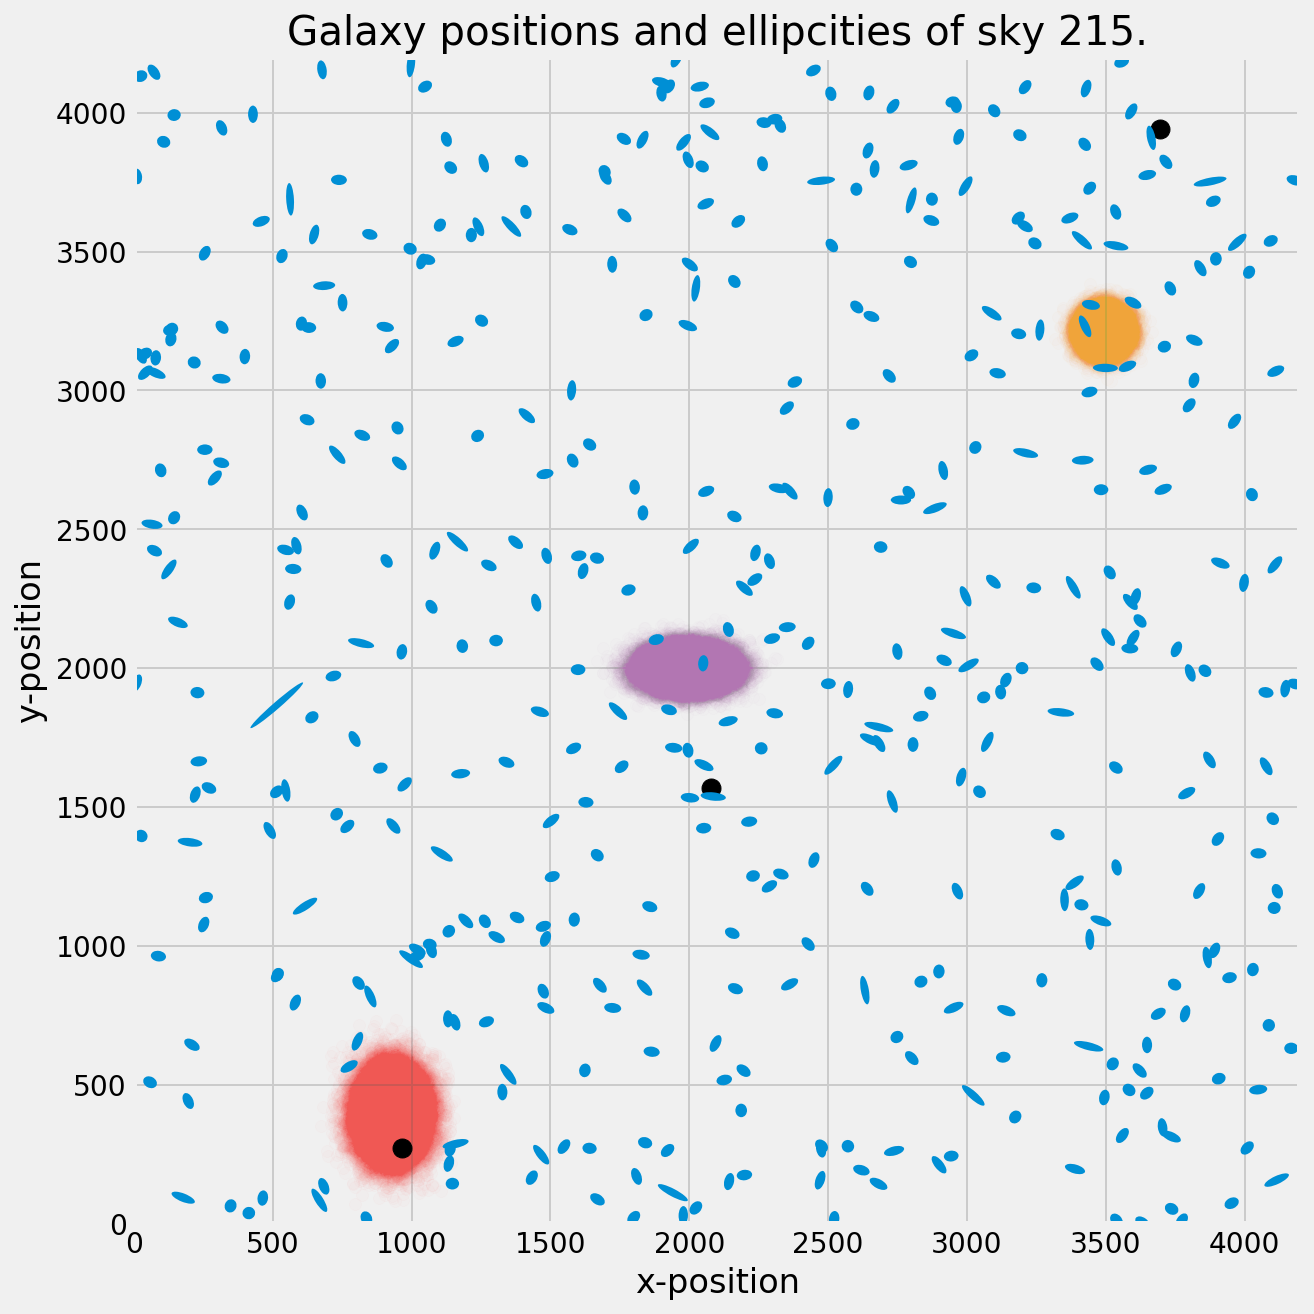

In [0]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

# Hex for red, purple, and yellow-orange
colors = ["#F15854", "#B276B2", "#FAA43A"]

t1 = posterior_large_halo_pred_val.reshape(50000,2)
t2 = posterior_small1_halo_pred_val.reshape(50000,2)
t3 = posterior_small2_halo_pred_val.reshape(50000,2)


plt.scatter(t1[:,0], t1[:,1], alpha = 0.015, c = colors[0])
plt.scatter(t2[:,0], t2[:,1], alpha = 0.015, c = colors[1])
plt.scatter(t3[:,0], t3[:,1], alpha = 0.015, c = colors[2])
    
for i in range(3):
    plt.scatter(halo_data[n_sky-1][3 + 2*i], halo_data[n_sky-1][4 + 2*i], 
            label = "True halo position", c = "k", s = 90)
    
#plt.legend(scatterpoints = 1)
plt.xlim(0, 4200)
plt.ylim(0, 4200);


This looks pretty good, though it took a long time for the system to (sort of) converge. Our optimization step would look something like this:

In [0]:
from DarkWorldsMetric import main_score

_halo_data = halo_data[n_sky - 1]

mean_posterior = [np.concatenate([halo_lar_mean_val, halo_sm1_mean_val, halo_sm2_mean_val])]
print(mean_posterior)

nhalo_all = _halo_data[0].reshape(1, 1)
x_true_all = _halo_data[3].reshape(1, 1)
y_true_all = _halo_data[4].reshape(1, 1)
x_ref_all = _halo_data[1].reshape(1, 1)
y_ref_all = _halo_data[2].reshape(1, 1)
sky_prediction = mean_posterior


print("Using the mean:")
main_score([1], x_true_all, y_true_all,
           x_ref_all, y_ref_all, sky_prediction)

# what's a bad score?
print("\n")
random_guess = np.random.randint(0, 4200, size=(1, 2))
print("Using a random location:", random_guess)
main_score([1], x_true_all, y_true_all,
           x_ref_all, y_ref_all, random_guess)


[array([ 927.32825,  396.16748, 1991.8611 , 1999.772  , 3490.9226 ,
       3213.2146 ], dtype=float32)]
Using the mean:
Your average distance in pixels you are away from the true halo is 4499.013326011586
Your average angular vector is 1.0
Your score for the training data is 5.499013326011586


Using a random location: [[2190 1060]]
Your average distance in pixels you are away from the true halo is 3251.9929880766967
Your average angular vector is 0.9999999999999999
Your score for the training data is 4.2519929880766965


4.2519929880766965

## References
1. Antifragile: Things That Gain from Disorder. New York: Random House. 2012. ISBN 978-1-4000-6782-4.
2.  [Tim Saliman's solution to the Dark World's Contest](http://www.timsalimans.com/observing-dark-worlds)
3. Silver, Nate. The Signal and the Noise: Why So Many Predictions Fail — but Some Don't. 1. Penguin Press HC, The, 2012. Print.     
4. Introducing Tensorflow Probability ([on Medium](https://medium.com/tensorflow/introducing-tensorflow-probability-dca4c304e245))
5. Tensorflow Probability Style Guide ([on Github](https://github.com/tensorflow/probability/blob/master/STYLE_GUIDE.md))
6. How Not To Program the Tensorflow Graph ([on KDnuggets](https://www.kdnuggets.com/2017/05/how-not-program-tensorflow-graph.html))
7. Tensorflow's Map Function ([link](https://www.tensorflow.org/api_docs/python/tf/map_fn))
8. Visualizing Tensorflow graphs in Jupyter Notebooks ([link](https://blog.jakuba.net/2017/05/30/tensorflow-visualization.html))
9. Tensorflow 1.8 Documentation ([link](https://www.tensorflow.org/api_docs/))
10. Tensorflow Probability whitepaper ([link](https://arxiv.org/abs/1711.10604))


In [0]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

#  "#F15854",  // red
#  "#5DA5DA",  // blue
#  "#FAA43A",  // orange
#  "#60BD68",  // green
#  "#F17CB0",  // pink
#  "#B2912F",  // brown
#  "#B276B2",  // purple
#  "#DECF3F",  // yellow
#  "#4D4D4D",  // gray
